<a href="https://colab.research.google.com/github/akhilesh-kanmanthreddy/2024_Science_Fair_Tumor_Evolution_Forecasting/blob/main/Science_fair_2024_Google_Colab_2_29_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Creating and Optimizing a System to Forcast the 3D Spatiotemporal Growth of Tumors Using Time Series Forecasting Models.**

Each year, nearly 2 million individuals in the United States alone receive a cancer diagnosis. Current cancer treatment methods primarily consist of surgery, radiation therapy, and tomotherapy. However, each method presents distinct challenges. Surgical interventions are often limited by the proximity of vital organs to the cancer site. Radiation therapy, while effective, poses risks as it can harm healthy tissue adjacent to the tumor. Meanwhile, tomotherapy relies on medical imaging for precise targeting, yet inaccuracies can result in cancer cells persisting and regrowing. Understanding 3D spatiotemporal growth of tumors and cancers is crucial for providing effective and accurate tomotherapy treatment. Traditional methods for tracking tumor growth are inaccurate and invasive. Methods such as MRI scans and biopsies are expensive, can lead to implications, and fall short in predicting tumor growth. As of now, tumor growth modeling primarily relies on partial differential equation (PDE) approaches, which are not only slow but also prone to inaccuracies. Therefore, this project aims to revolutionize tumor growth modeling by developing innovative software. The core goal is to create and refine an advanced system capable of accurately forecasting the spatiotemporal growth of tumors within a three-dimensional space, employing cutting-edge time series forecasting machine learning techniques; in hopes to personalize cancer treatment, aid in tomo-radiation therapy, and predict anatomical tumor development and type; to help medical professionals diagnose and treat tumors.

# Flow Diagram

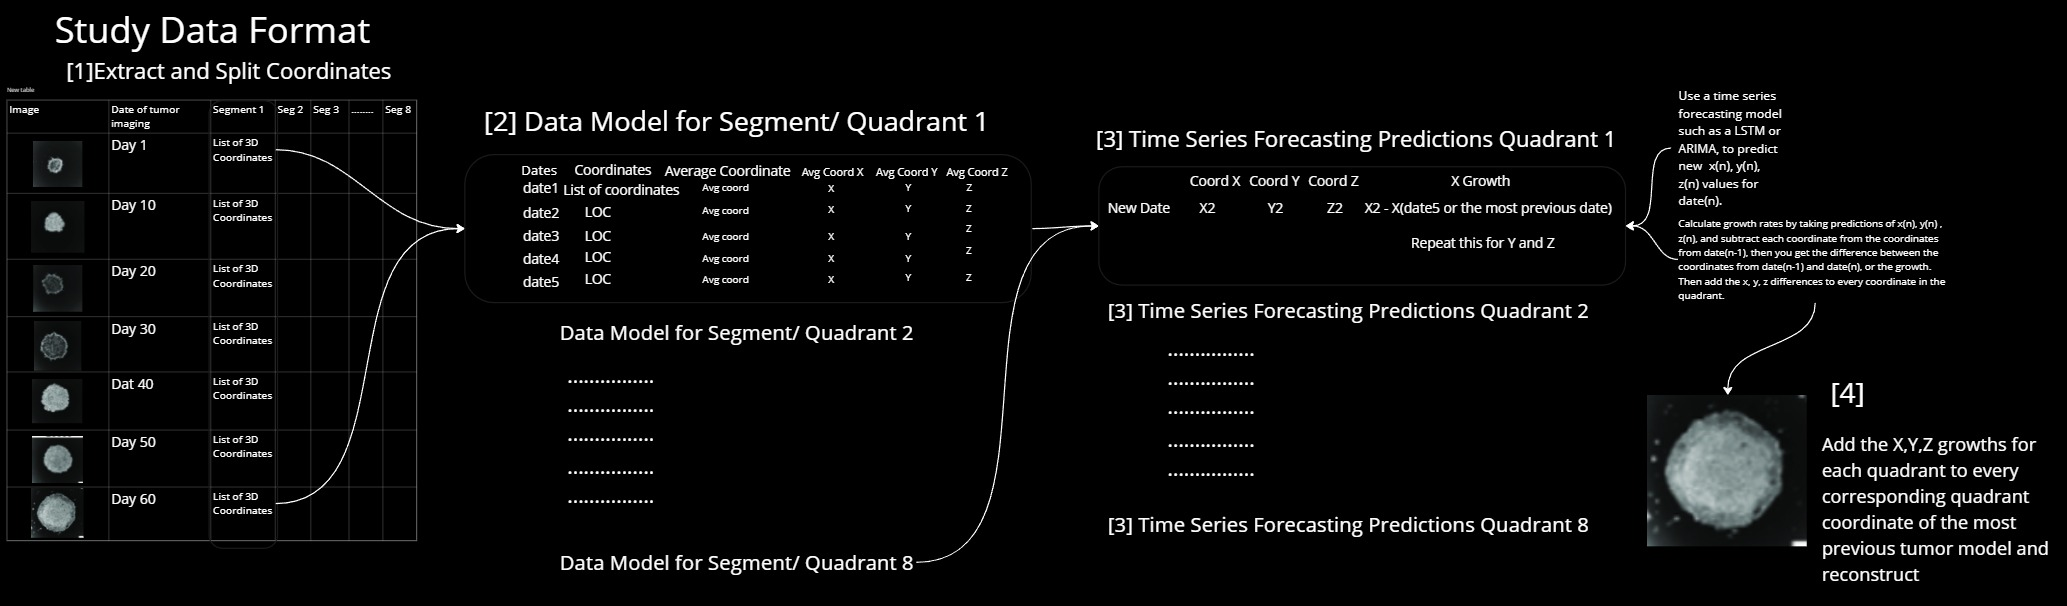

https://miro.com/welcomeonboard/dU56WU5HMWlPWE94WHhobmdhR2VhTWUwbzRheFAzYWJXWXNUSVoyNWpZTGRNaHlNazE4Zm1GQ0lneUlHUzhhNHwzNDU4NzY0NTQyMDA5MzY5NjExfDI=?share_link_id=196026559754

# Defining Fuctions

**Repeat for Each MRI in Series**

In [ ]:
#installs
!pip install tripy
!pip install pywavefront


In [ ]:
#imports
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from pywavefront import Wavefront
#from tripy.geometry import Point, Triangle

In [ ]:
#load obj points
def load_obj(file_path):
    vertices = []

    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if parts:
                if parts[0] == 'v' and len(parts) == 4:
                    # Read vertices (v x y z)
                    x, y, z = map(float, parts[1:])
                    vertices.append((x, y, z))

    return vertices

In [ ]:
#center obj points to (0,0,0)
def center_3d_model(obj_file_path):
    # Load the OBJ file
    obj = Wavefront(obj_file_path)
    # Extract vertex coordinates
    vertices = obj.vertices
    # Calculate the current center
    center = (
        sum(vertex[0] for vertex in vertices) / len(vertices),
        sum(vertex[1] for vertex in vertices) / len(vertices),
        sum(vertex[2] for vertex in vertices) / len(vertices)
    )
    # Translate to the origin
    centered_vertices = [(vertex[0] - center[0], vertex[1] - center[1], vertex[2] - center[2]) for vertex in vertices]
    # Save the centered model to a new OBJ file
    output_obj_file_path = obj_file_path.replace('.obj', '_centered.obj')
    with open(output_obj_file_path, 'w') as output_file:
        # Write vertices to the output OBJ file
        for vertex in centered_vertices:
            output_file.write(f"v {vertex[0]} {vertex[1]} {vertex[2]}\n")
    print(f"Centered model saved to {output_obj_file_path}")

In [ ]:
#Split Verticies from OBJ file into 8 seperate lists (1 per quadrant)
def split_vertices(vertices):
    segment_lists = [[] for _ in range(8)]  # Create 8 empty lists for each section
    for point in vertices:
        x, y, z = point
        # Calculate the octant index
        octant_index = (x >= 0) + 2 * (y >= 0) + 4 * (z >= 0)
        # Adjust the octant index to fall within the range of 0 to 7
        octant_index = min(octant_index, 7)
        # Add the point to the corresponding section list
        segment_lists[octant_index].append(point)
    return segment_lists

# output
# [[seg1coords],[seg2coords],[seg3coords], ...]

In [ ]:
#find average verts
def average_vertices(segment_lists):
    # Initialize lists to store the running totals for each dimension
    total_x = [0.0] * 8
    total_y = [0.0] * 8
    total_z = [0.0] * 8
    # Initialize lists to store the count of coordinates for each segment
    count_coords = [0] * 8

    # Iterate through each segment
    for segment_idx, segment in enumerate(segment_lists):
        # Iterate through each coordinate in the segment
        for coord in segment:
            x, y, z = coord
            total_x[segment_idx] += x
            total_y[segment_idx] += y
            total_z[segment_idx] += z
            count_coords[segment_idx] += 1

    # Calculate the average coordinates for each segment
    avg_vertices = [
        (
            total_x[segment_idx] / count_coords[segment_idx] if count_coords[segment_idx] != 0 else 0.0,
            total_y[segment_idx] / count_coords[segment_idx] if count_coords[segment_idx] != 0 else 0.0,
            total_z[segment_idx] / count_coords[segment_idx] if count_coords[segment_idx] != 0 else 0.0,
        )
        for segment_idx in range(8)
    ]

    return avg_vertices

# output
# [(x1, y1, z1), (x2, y2, z2). (x3, y3, z3), ... ]

**Combine Each MRI into 1 database and model**

In [ ]:
#Creating single database for paitient of average coordinates for study, input should be indices (list[0]) of the output from previous function
import pandas as pd
def add_patient_data(df, date, coordinates):
    # Create a new row with the given date and coordinates
    new_row = pd.DataFrame([coordinates], columns=df.columns[1:])  # Exclude the 'date' column
    new_row['date'] = date
    # Concatenate the existing DataFrame and the new row DataFrame
    df = pd.concat([df, new_row], ignore_index=True)
    return df
# Example usage:
# avg_vertices_list is the list of 8 vertices
# df = add_row_to_dataframe(df, '2023-07-15', avg_vertices_list)



```
# This is formatted as code
```

 **Finding the Growth of the Model**

ARIMA Model

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime, timedelta

def create_arima_model_and_predict(df, segment_name, future_date):
    # Extract 'date' and the selected segment's coordinates
    df_segment = df[['date', segment_name]]

    # Flatten the coordinates for the selected segment
    df_segment_flat = pd.DataFrame(df_segment[segment_name].to_list(), columns=[f'{segment_name}x', f'{segment_name}y', f'{segment_name}z'])

    # Combine the 'date' and flattened coordinates
    df_segment_flat['date'] = df['date']

    # Set 'date' as the index
    df_segment_flat.set_index('date', inplace=True)

    # Convert 'date' to datetime format
    df_segment_flat.index = pd.to_datetime(df_segment_flat.index)

    # Create a time series for the selected segment
    time_series = df_segment_flat[[f'{segment_name}x', f'{segment_name}y', f'{segment_name}z']]

    # Create ARIMA model for each coordinate (x, y, z)
    arima_models = {}
    for coordinate in ['x', 'y', 'z']:
        model = ARIMA(time_series[f'{segment_name}{coordinate}'], order=(1, 1, 1))
        fit_model = model.fit()
        arima_models[f'{segment_name}{coordinate}'] = fit_model

    # Predict future coordinates for the given future date
    future_date = pd.to_datetime(future_date)
    future_coordinates = {}
    for coordinate in ['x', 'y', 'z']:
        forecast = arima_models[f'{segment_name}{coordinate}'].get_forecast(steps=1)
        future_coordinates[f'{segment_name}{coordinate}'] = forecast.predicted_mean.values[0]

    # Display the predicted coordinates for the future date
    print(f'Predicted Coordinates for {future_date}:')
    print(f'{segment_name}x: {future_coordinates[f"{segment_name}x"]}')
    print(f'{segment_name}y: {future_coordinates[f"{segment_name}y"]}')
    print(f'{segment_name}z: {future_coordinates[f"{segment_name}z"]}')

    return future_coordinates


LSTM Nueral Netowrk

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from datetime import datetime, timedelta

def create_lstm_model_and_predict(df, segment_name, future_date):
    # Extract 'date' and the selected segment's coordinates
    df_segment = df[['date', segment_name]]

    # Flatten the coordinates for the selected segment
    df_segment_flat = pd.DataFrame(df_segment[segment_name].to_list(), columns=[f'{segment_name}x', f'{segment_name}y', f'{segment_name}z'])

    # Combine the 'date' and flattened coordinates
    df_segment_flat['date'] = df['date']

    # Set 'date' as the index
    df_segment_flat.set_index('date', inplace=True)

    # Convert 'date' to datetime format
    df_segment_flat.index = pd.to_datetime(df_segment_flat.index)

    # Create a time series for the selected segment
    time_series = df_segment_flat[[f'{segment_name}x', f'{segment_name}y', f'{segment_name}z']]

    # Normalize the data using Min-Max scaling
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(time_series)

    # Create sequences for LSTM model
    sequence_length = 3  # Adjust as needed
    sequences = []
    targets = []

    for i in range(len(scaled_data) - sequence_length):
        sequence = scaled_data[i:i + sequence_length]
        target = scaled_data[i + sequence_length]
        sequences.append(sequence)
        targets.append(target)

    sequences = np.array(sequences)
    targets = np.array(targets)

    # Build LSTM model
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', input_shape=(sequence_length, 3)))
    model.add(Dense(units=3))  # Output layer with 3 units for x, y, z

    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(sequences, targets, epochs=50, batch_size=32)

    # Predict future coordinates for the given future date
    future_date = pd.to_datetime(future_date)
    last_sequence = scaled_data[-sequence_length:]
    last_sequence = np.reshape(last_sequence, (1, sequence_length, 3))
    predicted_coordinates = model.predict(last_sequence)[0]

    # Inverse transform the predicted coordinates to the original scale
    predicted_coordinates = scaler.inverse_transform(predicted_coordinates.reshape(1, -1))

    # Display the predicted coordinates for the future date
    print(f'Predicted Coordinates for {future_date}:')
    print(f'{segment_name}x: {predicted_coordinates[0][0]}')
    print(f'{segment_name}y: {predicted_coordinates[0][1]}')
    print(f'{segment_name}z: {predicted_coordinates[0][2]}')

    return predicted_coordinates[0]

Exponential Regression

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from datetime import datetime, timedelta

def exponential_regression_and_predict(df, segment_name, future_date):
    # Extract 'date' and the selected segment's coordinates
    df_segment = df[['date', segment_name]]

    # Flatten the coordinates for the selected segment
    df_segment_flat = pd.DataFrame(df_segment[segment_name].to_list(), columns=[f'{segment_name}x', f'{segment_name}y', f'{segment_name}z'])

    # Combine the 'date' and flattened coordinates
    df_segment_flat['date'] = df['date']

    # Set 'date' as the index
    df_segment_flat.set_index('date', inplace=True)

    # Convert 'date' to datetime format
    df_segment_flat.index = pd.to_datetime(df_segment_flat.index)

    # Create a time series for the selected segment
    time_series = df_segment_flat[[f'{segment_name}x', f'{segment_name}y', f'{segment_name}z']]

    # Define the exponential function to fit
    def exponential_function(t, a, b, c):
        return a * np.exp(b * t) + c

    predicted_coordinates = {}

    for coord in ['x', 'y', 'z']:
        # Fit the exponential function to the time series data
        x = np.arange(len(time_series))
        popt, pcov = curve_fit(exponential_function, x, time_series[f'{segment_name}{coord}'], maxfev=1000)

        # Predict future coordinate for the given future date
        future_date = pd.to_datetime(future_date)
        future_index = len(time_series) + (future_date - time_series.index[-1]).days
        future_coordinate = exponential_function(future_index, *popt)

        # Display the predicted coordinate for the future date
        print(f'Predicted {segment_name}{coord} for {future_date}: {future_coordinate}')

        predicted_coordinates[f'{segment_name}{coord}'] = future_coordinate

    return predicted_coordinates



**Adding Growth to Tumor Model**

In [ ]:
def combine_segments(modified_segments):
    combined_vertices = []
    for segment in modified_segments:
        combined_vertices.extend(segment)
    return combined_vertices

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
import numpy as np

def plot_solid_volume(coordinates):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Create a convex hull from the coordinates
    hull = ConvexHull(coordinates)
    verts = np.array(coordinates)[hull.vertices]

    # Plot the convex hull as a solid volume
    mesh = Poly3DCollection([verts], alpha=0.25, edgecolor='k', linewidths=0.5)
    ax.add_collection3d(mesh)

    # Scatter plot for the original coordinates
    x, y, z = zip(*coordinates)
    ax.scatter(x, y, z, c='r', marker='o')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()

In [ ]:
from google.colab import files
# Function to save the modified model
def save_obj(file_path, vertices):
    with open(file_path, 'w') as f:
        for vertex in vertices:
            f.write(f"v {vertex[0]} {vertex[1]} {vertex[2]}\n")

In [ ]:
# add_growth function
import sys
def add_growth(model, growth_array):
    vertices = load_obj(model)
    segments = split_vertices(vertices)
    modified_segments = []
    for i, segment in enumerate(segments):
        modified_segment = []
        for vertex in segment:
            x, y, z = vertex
            x += growth_array[i * 3]
            y += growth_array[i * 3 + 1]
            z += growth_array[i * 3 + 2]
            modified_segment.append((x, y, z))
        modified_segments.append(modified_segment)
    modified_model = combine_segments(modified_segments)
    # Print the modified vertices
    original_stdout = sys.stdout

    with open('output.txt', 'w') as f:
      sys.stdout = f  # Change the standard output to the file
      print("Modified Vertices:")
      for vertex in modified_model:
        print(f"{vertex},")


    sys.stdout = original_stdout
    #print("Modified Vertices:")
    #for vertex in modified_model:
        #print(f"{vertex},")

# **Patient 040078 Case Study**


In [ ]:
#create dataframe
df_patient_040078 = pd.DataFrame(columns=['date', 'seg1', 'seg2', 'seg3', 'seg4', 'seg5', 'seg6', 'seg7', 'seg8'])  # Initialize an empty DataFrame

1900/01/01 model

In [ ]:
#load the vertices of the obj File
vertices = load_obj("/content/drive/MyDrive/Science Fair 2024 Data/patient 040078-12/040078N-obj/040078_19000101_AX_T1_FL3D_msk/tinker_centered.obj")
print(vertices)
#find average vertices
avg_vertices = average_vertices(split_vertices(vertices))
print(avg_vertices)
#add to df
date = "1900-01-01"
df_patient_040078 = add_patient_data(df_patient_040078, date, avg_vertices)

[(9.884377551020409, -14.328248299319728, -2.7998095238095244), (8.884377551020409, -14.328248299319728, -1.7998095238095244), (9.884377551020409, -14.328248299319728, -1.7998095238095244), (10.884377551020409, -13.328248299319728, -1.7998095238095244), (10.884377551020409, -13.328248299319728, -2.7998095238095244), (11.884377551020409, -12.328248299319728, -1.7998095238095244), (11.884377551020409, -13.328248299319728, -2.7998095238095244), (13.884377551020409, -9.328248299319728, -3.7998095238095244), (12.884377551020409, -8.328248299319728, -3.7998095238095244), (13.884377551020409, -7.3282482993197275, -3.7998095238095244), (13.884377551020409, -10.328248299319728, -3.7998095238095244), (12.884377551020409, -7.3282482993197275, -3.7998095238095244), (8.884377551020409, -10.328248299319728, -3.7998095238095244), (10.884377551020409, -8.328248299319728, -3.7998095238095244), (9.884377551020409, -8.328248299319728, -4.799809523809524), (10.884377551020409, -7.3282482993197275, -4.7998

1900/04/15 model

In [ ]:
#load the vertices of the obj File
vertices = load_obj("/content/drive/MyDrive/Science Fair 2024 Data/patient 040078-12/040078N-obj/040078_19000415_Ax_FSPGR_BRAVO_msk/tinker_centered.obj")
print(vertices)
#find average vertices
avg_vertices = average_vertices(split_vertices(vertices))
print(avg_vertices)
#add to df
date = "1900-04-15"
df_patient_040078 = add_patient_data(df_patient_040078, date, avg_vertices)

[(5.5423728813559325, -3.1313559322033897, -0.3389830508474576), (7.5423728813559325, -1.1313559322033897, -0.3389830508474576), (4.5423728813559325, -3.1313559322033897, -2.3389830508474576), (4.5423728813559325, -1.1313559322033897, -2.3389830508474576), (5.5423728813559325, -0.1313559322033898, -2.3389830508474576), (6.5423728813559325, -1.1313559322033897, -2.3389830508474576), (4.5423728813559325, -0.1313559322033898, -3.3389830508474576), (7.5423728813559325, -1.1313559322033897, -1.3389830508474576), (3.542372881355932, -0.1313559322033898, -4.338983050847458), (2.542372881355932, 0.8686440677966102, -4.338983050847458), (3.542372881355932, 0.8686440677966102, -3.3389830508474576), (4.5423728813559325, 0.8686440677966102, -3.3389830508474576), (7.5423728813559325, -0.1313559322033898, -0.3389830508474576), (7.5423728813559325, 0.8686440677966102, -1.3389830508474576), (6.5423728813559325, 0.8686440677966102, -2.3389830508474576), (2.542372881355932, -5.13135593220339, -0.3389830

1900/07/15 model

In [ ]:
#load the vertices of the obj File
vertices = load_obj("/content/drive/MyDrive/Science Fair 2024 Data/patient 040078-12/040078N-obj/040078_19000715_Ax_FSPGR_BRAVO_msk/tinker_centered.obj")
print(vertices)
#find average vertices
avg_vertices = average_vertices(split_vertices(vertices))
print(avg_vertices)
#add to df
date = "1900-07-15"
df_patient_040078 = add_patient_data(df_patient_040078, date, avg_vertices)

[(4.174273858921162, -4.817427385892116, -0.08298755186721962), (3.174273858921162, -5.817427385892116, -0.08298755186721962), (2.174273858921162, -4.817427385892116, 1.9170124481327804), (1.1742738589211619, -5.817427385892116, 1.9170124481327804), (1.1742738589211619, -6.817427385892116, 0.9170124481327804), (2.174273858921162, -6.817427385892116, -0.08298755186721962), (5.174273858921162, -1.8174273858921162, -1.0829875518672196), (5.174273858921162, -0.8174273858921162, -2.0829875518672196), (4.174273858921162, -2.817427385892116, -1.0829875518672196), (4.174273858921162, -1.8174273858921162, -1.0829875518672196), (3.174273858921162, -2.817427385892116, -2.0829875518672196), (3.174273858921162, -1.8174273858921162, -2.0829875518672196), (4.174273858921162, -0.8174273858921162, -2.0829875518672196), (2.174273858921162, -3.817427385892116, -3.0829875518672196), (1.1742738589211619, -3.817427385892116, -4.08298755186722), (1.1742738589211619, -2.817427385892116, -4.08298755186722), (1

1900/10/07

In [ ]:
#load the vertices of the obj File
vertices = load_obj("/content/drive/MyDrive/Science Fair 2024 Data/patient 040078-12/040078N-obj/040078_19001007_Ax_FSPGR_BRAVO_msk/tinker_centered.obj")
print(vertices)
#find average vertices
avg_vertices = average_vertices(split_vertices(vertices))
print(avg_vertices)
#add to df
date = "1900-10-07"
df_patient_040078 = add_patient_data(df_patient_040078, date, avg_vertices)

[(0.36917562724014336, -5.860215053763441, 1.096774193548387), (4.369175627240144, -4.860215053763441, 1.096774193548387), (1.3691756272401434, -6.860215053763441, 1.096774193548387), (1.3691756272401434, -7.860215053763441, 0.09677419354838701), (2.369175627240143, -6.860215053763441, 0.09677419354838701), (2.369175627240143, -6.860215053763441, 1.096774193548387), (3.369175627240143, -6.860215053763441, 0.09677419354838701), (3.369175627240143, -7.860215053763441, 0.09677419354838701), (0.36917562724014336, -6.860215053763441, 1.096774193548387), (0.36917562724014336, -7.860215053763441, 0.09677419354838701), (4.369175627240144, -4.860215053763441, -1.903225806451613), (4.369175627240144, -5.860215053763441, -1.903225806451613), (4.369175627240144, -5.860215053763441, -0.903225806451613), (3.369175627240143, -7.860215053763441, -1.903225806451613), (3.369175627240143, -6.860215053763441, -1.903225806451613), (2.369175627240143, -7.860215053763441, -0.903225806451613), (2.369175627240

1901/01/05

In [ ]:
#load the vertices of the obj File
vertices = load_obj("/content/drive/MyDrive/Science Fair 2024 Data/patient 040078-12/040078N-obj/040078_19010105_Ax_FSPGR_BRAVO_msk/tinker_centered.obj")
print(vertices)
#find average vertices
avg_vertices = average_vertices(split_vertices(vertices))
print(avg_vertices)
#add to df
date = "1901-01-05"
df_patient_040078 = add_patient_data(df_patient_040078, date, avg_vertices)

[(6.4235751295336785, -5.020476683937824, -1.2150259067357512), (6.4235751295336785, -7.020476683937824, 1.7849740932642488), (7.4235751295336785, -5.020476683937824, -0.21502590673575117), (7.4235751295336785, -7.020476683937824, 0.7849740932642488), (7.4235751295336785, -6.020476683937824, -0.21502590673575117), (5.4235751295336785, -8.020476683937824, 1.7849740932642488), (5.4235751295336785, -5.020476683937824, 1.7849740932642488), (6.4235751295336785, -5.020476683937824, 1.7849740932642488), (7.4235751295336785, -5.020476683937824, 0.7849740932642488), (4.4235751295336785, -7.020476683937824, 1.7849740932642488), (4.4235751295336785, -6.020476683937824, 1.7849740932642488), (0.42357512953367876, -7.020476683937824, 1.7849740932642488), (2.423575129533679, -7.020476683937824, 1.7849740932642488), (3.423575129533679, -8.020476683937824, 1.7849740932642488), (1.4235751295336787, -8.020476683937824, 1.7849740932642488), (0.42357512953367876, -8.020476683937824, 0.7849740932642488), (5

In [ ]:
print(df_patient_040078.to_markdown(index=False))

| date       | seg1                                                            | seg2                                                           | seg3                                                          | seg4                                                          | seg5                                                          | seg6                                                          | seg7                                                          | seg8                                                        |
|:-----------|:----------------------------------------------------------------|:---------------------------------------------------------------|:--------------------------------------------------------------|:--------------------------------------------------------------|:--------------------------------------------------------------|:--------------------------------------------------------------|:--------------------------------------------------------------|:------

predict future coordinates for 1901/03/05

ARIMA MODEL

In [ ]:
#ARIMA MODEL repeat for each segment
future_date = '1901-03-05'  # Replace with your desired future date
#repeat for segments 1-8
predicted_coordinates = create_arima_model_and_predict(df_patient_040078, 'seg1', future_date)

In [ ]:
predicted_coordinates = create_arima_model_and_predict(df_patient_040078, 'seg2', future_date)

In [ ]:
predicted_coordinates = create_arima_model_and_predict(df_patient_040078, 'seg3', future_date)

In [ ]:
predicted_coordinates = create_arima_model_and_predict(df_patient_040078, 'seg4', future_date)

In [ ]:
predicted_coordinates = create_arima_model_and_predict(df_patient_040078, 'seg5', future_date)

In [ ]:
predicted_coordinates = create_arima_model_and_predict(df_patient_040078, 'seg6', future_date)

In [ ]:
predicted_coordinates = create_arima_model_and_predict(df_patient_040078, 'seg7', future_date)

In [ ]:
predicted_coordinates = create_arima_model_and_predict(df_patient_040078, 'seg8', future_date)

In [ ]:
#create growth manually using excel
growth_array = [-0.2619175805,-0.3759871096,0.229613578,0.6330660428,-0.406253296,-0.1495338845,-0.2977974492,0.3797653788,0.3034157099,-0.5760971326,0.6193957705,0.2433839051,0.6560348848,-0.1046345626,0.1501807227,-1.376556697,-0.1937271083,-0.5272596173,-0.09203880579,0.1986907279,-0.454798752,0.06950373243,0.03055061083,-0.2483518514]
len(growth_array)

24

In [ ]:
#create prediction model
add_growth("/content/drive/MyDrive/Science Fair 2024 Data/patient 040078-12/040078N-obj/040078_19010105_Ax_FSPGR_BRAVO_msk/tinker_centered.obj", growth_array)

LSTM NN

In [ ]:
#LSTM NN
future_date = '1901-03-05'  # Replace with your desired future date
#repeat for segments 1-8
predicted_coordinates = create_lstm_model_and_predict(df_patient_040078, 'seg1', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040078, 'seg2', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040078, 'seg3', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040078, 'seg4', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040078, 'seg5', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040078, 'seg6', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040078, 'seg7', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040078, 'seg8', future_date)

In [ ]:
#create growth manually using excel
growth_array = [-1.09774386,0.06854537829,-0.2593882439,-0.5379588457,-1.333065737,-0.2015356688,-0.6824203979,0.6735437959,-0.7259732867,-0.18914186,-0.5320963484,-0.02602026445,-0.06178592373,0.5035793434,-0.2489088258,-0.4008120108,-2.614514905,-0.6585564421,-1.775696638,-0.1679271706,-0.33997271,-0.4198802614,0.01017800268,-0.1285241554]
len(growth_array)


24

In [ ]:
add_growth("/content/drive/MyDrive/Science Fair 2024 Data/patient 040078-12/040078N-obj/040078_19010105_Ax_FSPGR_BRAVO_msk/tinker_centered.obj", growth_array)

Exponential regression

In [ ]:
#Exponential regression
future_date = '1901-03-05'  # Replace with your desired future date
#repeat for segments 1-8
predicted_coordinates = exponential_regression_and_predict(df_patient_040078, 'seg1', future_date)

Predicted seg1x for 1901-03-05 00:00:00: 71.21797316988886
Predicted seg1y for 1901-03-05 00:00:00: 43.60722207196886
Predicted seg1z for 1901-03-05 00:00:00: 0.8213311855049596


In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_040078, 'seg2', future_date)

Predicted seg2x for 1901-03-05 00:00:00: -68.24951345507725
Predicted seg2y for 1901-03-05 00:00:00: 58.4218345064146
Predicted seg2z for 1901-03-05 00:00:00: 3.030444922249899


In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_040078, 'seg3', future_date)

Predicted seg3x for 1901-03-05 00:00:00: 53.19845973061456
Predicted seg3y for 1901-03-05 00:00:00: -58.91697262080015
Predicted seg3z for 1901-03-05 00:00:00: 21.076158995635524


In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_040078, 'seg4', future_date)

Predicted seg4x for 1901-03-05 00:00:00: -87.02032083143422
Predicted seg4y for 1901-03-05 00:00:00: -69.26934184115453
Predicted seg4z for 1901-03-05 00:00:00: 14.447391157877064


In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_040078, 'seg5', future_date)

Predicted seg5x for 1901-03-05 00:00:00: 69.96747818590666
Predicted seg5y for 1901-03-05 00:00:00: 85.47617063652433
Predicted seg5z for 1901-03-05 00:00:00: -9.929572267102685


In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_040078, 'seg6', future_date)

Predicted seg6x for 1901-03-05 00:00:00: -78.2273271633785
Predicted seg6y for 1901-03-05 00:00:00: 61.28611032209301
Predicted seg6z for 1901-03-05 00:00:00: -13.718709559168474


In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_040078, 'seg7', future_date)

Predicted seg7x for 1901-03-05 00:00:00: 55.021733927498644
Predicted seg7y for 1901-03-05 00:00:00: -77.9802900093564
Predicted seg7z for 1901-03-05 00:00:00: -3.268828627393532


In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_040078, 'seg8', future_date)

Predicted seg8x for 1901-03-05 00:00:00: -56.230390419113974
Predicted seg8y for 1901-03-05 00:00:00: -78.81741545231489
Predicted seg8z for 1901-03-05 00:00:00: -2.2621607909087516


In [ ]:
#create growth manually using excel
growth_array = [74.4547754,48.15600064,3.753338224,-71.98681407,62.87368374,5.716059064,57.2855229,-63.89649594,22.92948277,-90.34389596,-73.56886516,16.68241706,73.45694653,88.0856908,-12.51889419,-81.79090229,65.36658701,-16.36368365,58.77162819,-81.98022149,-6.012986394,-60.55396555,-82.49693877,-4.897134884]
len(growth_array)

24

In [ ]:
add_growth("/content/drive/MyDrive/Science Fair 2024 Data/patient 040078-12/040078N-obj/040078_19010105_Ax_FSPGR_BRAVO_msk/tinker_centered.obj", growth_array)

Modified Vertices:


[(70.87835052953368, 48.13552395606218, -1.461687682735751),
 (72.87835052953368, 48.13552395606218, -2.461687682735751),
 (73.87835052953368, 48.13552395606218, -2.461687682735751),
 (67.87835052953368, 46.13552395606218, 2.538312317264249),
 (67.87835052953368, 46.13552395606218, 3.538312317264249),
 (68.87835052953368, 45.13552395606218, 3.538312317264249),
 (68.87835052953368, 45.13552395606218, 2.538312317264249),
 (68.87835052953368, 44.13552395606218, 2.538312317264249),
 (68.87835052953368, 48.13552395606218, 1.538312317264249),
 (69.87835052953368, 48.13552395606218, -0.461687682735751),
 (69.87835052953368, 44.13552395606218, 1.538312317264249),
 (69.87835052953368, 45.13552395606218, 1.538312317264249),
 (69.87835052953368, 45.13552395606218, 0.538312317264249),
 (69.87835052953368, 44.13552395606218, 0.538312317264249),
 (69.87835052953368, 47.13552395606218, -0.461687682735751),
 (69.87835052953368, 44.13552395606218, -0.461687682735751),
 (69.87835052953368, 46.1355239560

# **Patient 010061 Case Study**

In [ ]:
#create dataframe
df_patient_010061 = pd.DataFrame(columns=['date', 'seg1', 'seg2', 'seg3', 'seg4', 'seg5', 'seg6', 'seg7', 'seg8'])  # Initialize an empty DataFrame

1901/09/05 model

In [ ]:
#load the vertices of the obj File
vertices = load_obj("/content/drive/MyDrive/Science Fair 2024 Data/patient 010061-6/010061N-obj/010061_19010905_eTRA-3D-T1Gd_msk/tinker_centered.obj")
print(vertices)
#find average vertices
avg_vertices = average_vertices(split_vertices(vertices))
print(avg_vertices)
#add to df
date = "1901-09-05"
df_patient_010061 = add_patient_data(df_patient_010061, date, avg_vertices)

[(-4.509933774834437, 2.4304635761589406, 2.122516556291391), (-4.509933774834437, 3.4304635761589406, 2.122516556291391), (-4.509933774834437, 3.4304635761589406, -0.8774834437086092), (-4.509933774834437, 2.4304635761589406, -0.8774834437086092), (-0.5099337748344371, 0.4304635761589404, -2.877483443708609), (-0.5099337748344371, 1.4304635761589404, -3.877483443708609), (-0.5099337748344371, -5.569536423841059, -0.8774834437086092), (-0.5099337748344371, 0.4304635761589404, 3.122516556291391), (-1.509933774834437, 2.4304635761589406, -3.877483443708609), (-2.5099337748344372, 1.4304635761589404, 2.122516556291391), (-1.509933774834437, 0.4304635761589404, -2.877483443708609), (-3.5099337748344372, 1.4304635761589404, 1.1225165562913908), (0.4900662251655629, 4.430463576158941, 1.1225165562913908), (-2.5099337748344372, 0.4304635761589404, 1.1225165562913908), (3.4900662251655628, -1.5695364238410596, -2.877483443708609), (2.4900662251655628, -1.5695364238410596, -2.877483443708609), 

1901/10/16 model

In [ ]:
#load the vertices of the obj File
vertices = load_obj("/content/drive/MyDrive/Science Fair 2024 Data/patient 010061-6/010061N-obj/010061_19011016_eTRA-3D-T1Gd_msk/tinker_centered.obj")
print(vertices)
#find average vertices
avg_vertices = average_vertices(split_vertices(vertices))
print(avg_vertices)
#add to df
date = "1901-10-16"
df_patient_010061 = add_patient_data(df_patient_010061, date, avg_vertices)

[(1.673202614379085, -1.7450980392156863, -3.163398692810458), (0.673202614379085, -1.7450980392156863, -4.163398692810458), (0.673202614379085, -1.7450980392156863, -3.163398692810458), (3.673202614379085, -0.7450980392156863, -3.163398692810458), (2.673202614379085, -0.7450980392156863, -3.163398692810458), (1.673202614379085, -0.7450980392156863, -3.163398692810458), (3.673202614379085, -1.7450980392156863, -4.163398692810458), (2.673202614379085, -1.7450980392156863, -4.163398692810458), (0.673202614379085, -0.7450980392156863, -3.163398692810458), (-0.32679738562091504, -0.7450980392156863, -4.163398692810458), (1.673202614379085, -2.7450980392156863, -4.163398692810458), (0.673202614379085, -2.7450980392156863, -5.163398692810458), (0.673202614379085, -3.7450980392156863, -4.163398692810458), (3.673202614379085, -3.7450980392156863, -3.163398692810458), (3.673202614379085, -2.7450980392156863, -4.163398692810458), (2.673202614379085, -3.7450980392156863, -4.163398692810458), (-0.

In [ ]:
print(df_patient_010061.to_markdown(index=False))

| date       | seg1                                                          | seg2                                                          | seg3                                                           | seg4                                                          | seg5                                                           | seg6                                                        | seg7                                                          | seg8                                                        |
|:-----------|:--------------------------------------------------------------|:--------------------------------------------------------------|:---------------------------------------------------------------|:--------------------------------------------------------------|:---------------------------------------------------------------|:------------------------------------------------------------|:--------------------------------------------------------------|:------------

Predict future coordinates 1901/12/18


ARIMA Model

In [ ]:
#ARIMA MODEL repeat for each segment
future_date = '1901-12-18'  # Replace with your desired future date
#repeat for segments 1-8
predicted_coordinates = create_arima_model_and_predict(df_patient_010061, 'seg1', future_date)

In [ ]:
#repeat for segments 1-8
predicted_coordinates = create_arima_model_and_predict(df_patient_010061, 'seg2', future_date)

In [ ]:
#repeat for segments 1-8
predicted_coordinates = create_arima_model_and_predict(df_patient_010061, 'seg3', future_date)

In [ ]:
#repeat for segments 1-8
predicted_coordinates = create_arima_model_and_predict(df_patient_010061, 'seg4', future_date)

In [ ]:
#repeat for segments 1-8
predicted_coordinates = create_arima_model_and_predict(df_patient_010061, 'seg5', future_date)

In [ ]:
#repeat for segments 1-8
predicted_coordinates = create_arima_model_and_predict(df_patient_010061, 'seg6', future_date)

In [ ]:
#repeat for segments 1-8
predicted_coordinates = create_arima_model_and_predict(df_patient_010061, 'seg7', future_date)

In [ ]:
#repeat for segments 1-8
predicted_coordinates = create_arima_model_and_predict(df_patient_010061, 'seg8', future_date)

In [ ]:
#create growth manually using excel
growth_array = [0.4388749517,-0.6242395815,0.1970014159,-0.6079276133,0.1295261502,1.293150399,4.720883529,0.3727721047,-0.2210514652,-0.1506812161,0.2118653697,0.05088162828,-0.2497445235,-0.02416300499,-0.819423002,-0.1671518576,0.4640421733,-0.9887208945,-0.3265669518,0.04169740483,-0.01146482522,0.2454275122,-0.3527849318,-0.4854475529]
len(growth_array)

24

In [ ]:
#create prediction model
add_growth("/content/drive/MyDrive/Science Fair 2024 Data/patient 010061-6/010061N-obj/010061_19011016_eTRA-3D-T1Gd_msk/tinker_centered.obj", growth_array)

LSTM NN

In [ ]:
#LSTM NN
future_date = '1901-12-18'  # Replace with your desired future date
#repeat for segments 1-8
predicted_coordinates = create_lstm_model_and_predict(df_patient_010061, 'seg1', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_010061, 'seg2', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_010061, 'seg3', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_010061, 'seg4', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_010061, 'seg5', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_010061, 'seg6', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_010061, 'seg7', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_010061, 'seg8', future_date)

In [ ]:
#create growth manually using excel
growth_array = [0.006070418763,-0.407686356,-0.007108452118,-0.01340684192,0.002335042179,0.07213106164,-0.003793049075,-0.001089948319,-0.08399257256,-0.04531221575,0.01239512518,-0.002941068522,-0.001981874697,-0.01213295787,-0.1421847577,-0.08002614111,0.0251334266,-0.3361178593,-0.2056094499,-0.0007966503443,-0.008091480529,-0.01025019128,-0.004572800094,-0.2375605128]
len(growth_array)

24

In [ ]:
#create prediction model
add_growth("/content/drive/MyDrive/Science Fair 2024 Data/patient 010061-6/010061N-obj/010061_19011016_eTRA-3D-T1Gd_msk/tinker_centered.obj", growth_array)

Exponential regression

In [ ]:
#Exponential regression
future_date = '1901-12-18'  # Replace with your desired future date
#repeat for segments 1-8
predicted_coordinates = exponential_regression_and_predict(df_patient_010061, 'seg1', future_date)

In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_010061, 'seg2', future_date)

In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_010061, 'seg3', future_date)

In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_010061, 'seg4', future_date)

In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_010061, 'seg5', future_date)

In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_010061, 'seg6', future_date)

In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_010061, 'seg7', future_date)

In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_010061, 'seg8', future_date)

In [ ]:
#create growth manually using excel
growth_array = [0.1463619443,-0.2081461282,0.0656754534,-0.2026816047,0.0432580232,0.4310804188,0.1225294162,0.1243417945,-0.07377704257,-0.05024924175,0.07066628745,0.01703247845,-0.08326768529,-0.008146128208,-0.2732134355,-0.05577537084,0.1546997216,-0.3295961027,-0.1089242509,0.01397508391,-0.00408885636,0.08181167979,-0.1176699377,-0.1618377741]
len(growth_array)

24

In [ ]:
#create prediction model
add_growth("/content/drive/MyDrive/Science Fair 2024 Data/patient 010061-6/010061N-obj/010061_19011016_eTRA-3D-T1Gd_msk/tinker_centered.obj", growth_array)

# **Patient 040024 Case Study**

In [ ]:
#create dataframe
df_patient_040024 = pd.DataFrame(columns=['date', 'seg1', 'seg2', 'seg3', 'seg4', 'seg5', 'seg6', 'seg7', 'seg8'])  # Initialize an empty DataFrame

1900/01/01

In [ ]:
#load the vertices of the obj File
vertices = load_obj("/content/drive/MyDrive/Science Fair 2024 Data/patient 040024-12/040024N-obj/040024_19000101_AX_T1_FL3D_msk/tinker_centered.obj")
print(vertices)
#find average vertices
avg_vertices = average_vertices(split_vertices(vertices))
print(avg_vertices)
#add to df
date = "1900-01-01"
df_patient_040024 = add_patient_data(df_patient_040024, date, avg_vertices)

[(-8.51365409622887, -15.690182054616384, -4.791612483745123), (-8.51365409622887, -14.690182054616384, -5.791612483745123), (-8.51365409622887, -13.690182054616384, -6.791612483745123), (-7.513654096228869, -12.690182054616384, -6.791612483745123), (-7.513654096228869, -13.690182054616384, -5.791612483745123), (-6.513654096228869, -15.690182054616384, -5.791612483745123), (-7.513654096228869, -15.690182054616384, -5.791612483745123), (-16.51365409622887, -8.690182054616384, -1.7916124837451228), (-16.51365409622887, -8.690182054616384, -0.7916124837451228), (-16.51365409622887, -10.690182054616384, -1.7916124837451228), (-16.51365409622887, -11.690182054616384, -1.7916124837451228), (-15.51365409622887, -11.690182054616384, -0.7916124837451228), (-15.51365409622887, -10.690182054616384, -0.7916124837451228), (-16.51365409622887, -9.690182054616384, -0.7916124837451228), (-16.51365409622887, -9.690182054616384, -2.791612483745123), (-16.51365409622887, -8.690182054616384, -3.7916124837

1900/05/21

In [ ]:
#load the vertices of the obj File
vertices = load_obj("/content/drive/MyDrive/Science Fair 2024 Data/patient 040024-12/040024N-obj/040024_19000521_AX_T1_FL3D_msk/tinker_centered.obj")
print(vertices)
#find average vertices
avg_vertices = average_vertices(split_vertices(vertices))
print(avg_vertices)
#add to df
date = "1900-05-21"
df_patient_040024 = add_patient_data(df_patient_040024, date, avg_vertices)

[(-4.3, -6.454237288135594, 0.49661016949152526), (-4.3, -7.454237288135594, 0.49661016949152526), (-1.3, -7.454237288135594, -2.5033898305084747), (-3.3, -7.454237288135594, -2.5033898305084747), (-4.3, -7.454237288135594, -2.5033898305084747), (-1.3, -6.454237288135594, -3.5033898305084747), (-0.3, -5.454237288135594, -3.5033898305084747), (-3.3, -6.454237288135594, -3.5033898305084747), (-5.3, -4.454237288135594, 0.49661016949152526), (-6.3, -4.454237288135594, 0.49661016949152526), (-7.3, -5.454237288135594, -0.5033898305084747), (-6.3, -6.454237288135594, 0.49661016949152526), (-5.3, -7.454237288135594, 0.49661016949152526), (-7.3, -6.454237288135594, -0.5033898305084747), (-6.3, -7.454237288135594, -0.5033898305084747), (-5.3, -7.454237288135594, -2.5033898305084747), (-7.3, -5.454237288135594, -2.5033898305084747), (-8.3, -5.454237288135594, -1.5033898305084747), (-8.3, -4.454237288135594, -1.5033898305084747), (-7.3, -6.454237288135594, -1.5033898305084747), (-6.3, -7.454237288

1900/09/23

In [ ]:
#load the vertices of the obj File
vertices = load_obj("/content/drive/MyDrive/Science Fair 2024 Data/patient 040024-12/040024N-obj/040024_19000923_AX_T1_FL3D_msk/tinker_centered.obj")
print(vertices)
#find average vertices
avg_vertices = average_vertices(split_vertices(vertices))
print(avg_vertices)
#add to df
date = "1900-09-23"
df_patient_040024 = add_patient_data(df_patient_040024, date, avg_vertices)

[(4.966471615720524, -13.281196506550218, 0.5807860262008733), (3.9664716157205238, -13.281196506550218, 1.5807860262008733), (2.9664716157205238, -13.281196506550218, 1.5807860262008733), (2.9664716157205238, -13.281196506550218, 0.5807860262008733), (8.966471615720524, 5.718803493449782, 1.5807860262008733), (9.966471615720524, 4.718803493449782, 1.5807860262008733), (8.966471615720524, 4.718803493449782, 0.5807860262008733), (-1.033528384279476, 5.718803493449782, -4.419213973799127), (-0.03352838427947602, 4.718803493449782, -4.419213973799127), (-0.03352838427947602, 2.718803493449782, -4.419213973799127), (0.966471615720524, 1.7188034934497816, -4.419213973799127), (0.966471615720524, -0.2811965065502184, -4.419213973799127), (-7.033528384279476, -1.2811965065502184, -3.4192139737991267), (-8.033528384279476, -0.2811965065502184, -3.4192139737991267), (-7.033528384279476, -0.2811965065502184, -4.419213973799127), (8.966471615720524, 3.814803493449782, 0.5807860262008733), (-9.033

1900/11/24

In [ ]:
#load the vertices of the obj File
vertices = load_obj("/content/drive/MyDrive/Science Fair 2024 Data/patient 040024-12/040024N-obj/040024_19001124_AX_T1_FL3D_msk/tinker_centered.obj")
print(vertices)
#find average vertices
avg_vertices = average_vertices(split_vertices(vertices))
print(avg_vertices)
#add to df
date = "1900-11-24"
df_patient_040024 = add_patient_data(df_patient_040024, date, avg_vertices)

[(-29.636178082644626, 1.1403552727272728, -1.8597659834710765), (-29.636178082644626, 3.1403552727272728, -3.8597659834710765), (-29.636178082644626, 1.1403552727272728, -3.8597659834710765), (21.363821917355374, 2.1403552727272728, -1.8597659834710765), (21.363821917355374, 1.1403552727272728, -2.8597659834710765), (20.363821917355374, 2.1403552727272728, -2.8597659834710765), (-29.636178082644626, 0.14035527272727277, -2.8597659834710765), (-29.636178082644626, -1.8596447272727272, -2.8597659834710765), (-29.636178082644626, -0.8596447272727272, -1.8597659834710765), (21.363821917355374, 4.140355272727273, -1.8597659834710765), (20.363821917355374, 5.140355272727273, -1.8597659834710765), (20.363821917355374, 3.1403552727272728, -2.8597659834710765), (12.363821917355372, -27.859644727272727, 7.1402340165289235), (11.363821917355372, -27.859644727272727, 8.140234016528924), (9.363821917355372, -27.859644727272727, 8.140234016528924), (9.363821917355372, -27.859644727272727, 7.1402340

In [ ]:
print(df_patient_040024.to_markdown(index=False))

| date       | seg1                                                           | seg2                                                          | seg3                                                          | seg4                                                         | seg5                                                          | seg6                                                        | seg7                                                         | seg8                                                        |
|:-----------|:---------------------------------------------------------------|:--------------------------------------------------------------|:--------------------------------------------------------------|:-------------------------------------------------------------|:--------------------------------------------------------------|:------------------------------------------------------------|:-------------------------------------------------------------|:------------------

predict future coordinates for 1901/01/05

**Arima Model**

In [ ]:
#ARIMA MODEL repeat for each segment
future_date = '1901-01-05'  # Replace with your desired future date
#repeat for segments 1-8
predicted_coordinates = create_arima_model_and_predict(df_patient_040024, 'seg1', future_date)

In [ ]:
predicted_coordinates = create_arima_model_and_predict(df_patient_040024, 'seg2', future_date)

In [ ]:
predicted_coordinates = create_arima_model_and_predict(df_patient_040024, 'seg3', future_date)

In [ ]:
predicted_coordinates = create_arima_model_and_predict(df_patient_040024, 'seg4', future_date)

In [ ]:
predicted_coordinates = create_arima_model_and_predict(df_patient_040024, 'seg5', future_date)

In [ ]:
predicted_coordinates = create_arima_model_and_predict(df_patient_040024, 'seg6', future_date)

In [ ]:
predicted_coordinates = create_arima_model_and_predict(df_patient_040024, 'seg7', future_date)

In [ ]:
predicted_coordinates = create_arima_model_and_predict(df_patient_040024, 'seg8', future_date)

In [ ]:
#create growth manually using excel
growth_array = [-5.481974652,3.704677323,-1.665202675,1.720068285,4.188325246,1.481227871,-4.604534868,3.587687822,-1.745976053,3.473009032,3.69598937,-1.722237383,3.00155807,-3.275277741,-1.212239838,3.156445346,3.285518621,1.632912892,3.179811378,3.480745336,-1.20442288,-2.560761854,-2.806690922,1.520188954]
len(growth_array)


24

In [ ]:
#create prediction model
add_growth("/content/drive/MyDrive/Science Fair 2024 Data/patient 040024-12/040024N-obj/040024_19001124_AX_T1_FL3D_msk/tinker_centered.obj", growth_array)

**LSTM NN**

In [ ]:
#LSTM NN
future_date = '1901-01-05'  # Replace with your desired future date
#repeat for segments 1-8
predicted_coordinates = create_lstm_model_and_predict(df_patient_040024, 'seg1', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040024, 'seg2', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040024, 'seg3', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040024, 'seg4', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040024, 'seg5', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040024, 'seg6', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040024, 'seg7', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040024, 'seg8', future_date)

In [ ]:
#create growth manually using excel
growth_array = [0.06463924976,-0.05555547419,0.02257411974,-0.2481368291,0.4183303728,-0.06217859803,0.0122836484,-2.227886079,-0.2138835916,-3.426074544,-4.571083923,0.1142517707,-0.07074673248,-0.00192413771,-0.5353222384,-5.696748066,-0.0163077308,-1.217062946,0.0236020704,-4.222850271,-0.6551464845,-3.227917963,-3.297519262,-1.504071511]
len(growth_array)

24

In [ ]:
#create prediction model
add_growth("/content/drive/MyDrive/Science Fair 2024 Data/patient 040024-12/040024N-obj/040024_19001124_AX_T1_FL3D_msk/tinker_centered.obj", growth_array)

**Exponential Regression**

In [ ]:
#Exponential regression
future_date = '1901-01-05'  # Replace with your desired future date
#repeat for segments 1-8
predicted_coordinates = exponential_regression_and_predict(df_patient_040024, 'seg1', future_date)

In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_040024, 'seg2', future_date)

In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_040024, 'seg3', future_date)

In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_040024, 'seg4', future_date)

In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_040024, 'seg5', future_date)

In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_040024, 'seg6', future_date)

In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_040024, 'seg7', future_date)

In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_040024, 'seg8', future_date)

In [ ]:
#create growth manually using excel
growth_array = [55.27905134,27.43230067,17.23536057,-1.30,12.69181687,5.882427871,36.41104429,-8.08,19.16204728,-7.58,-3.75,8.464609487,7.502102153,31.5779084,-1.83,-2.79,26.56573255,-3.15,24.10471677,-3.67,-1.07,-2.26,-1.03,-1.81]
len(growth_array)

24

In [ ]:
#create prediction model
add_growth("/content/drive/MyDrive/Science Fair 2024 Data/patient 040024-12/040024N-obj/040024_19001124_AX_T1_FL3D_msk/tinker_centered.obj", growth_array)

# **Patient 040028 Case Study**

In [ ]:
#create dataframe
df_patient_040028 = pd.DataFrame(columns=['date', 'seg1', 'seg2', 'seg3', 'seg4', 'seg5', 'seg6', 'seg7', 'seg8'])  # Initialize an empty DataFrame

1900/01/01

In [ ]:
#load the vertices of the obj File
vertices = load_obj("/content/drive/MyDrive/Science Fair 2024 Data/patient 040028-14/040028N-obj/040028_19000101_AX_T1_FL3D_msk/tinker_centered.obj")
print(vertices)
#find average vertices
avg_vertices = average_vertices(split_vertices(vertices))
print(avg_vertices)
#add to df
date = "1900-01-01"
df_patient_040028 = add_patient_data(df_patient_040028, date, avg_vertices)

[(-3.1161476394849785, -19.080061802575106, -0.3880927038626618), (-2.1161476394849785, -19.080061802575106, 0.6119072961373382), (7.8838523605150215, 13.919938197424893, -4.388092703862662), (17.88385236051502, -8.080061802575107, -1.3880927038626618), (-5.1161476394849785, -19.080061802575106, 0.6119072961373382), (4.8838523605150215, 15.919938197424893, -5.388092703862662), (-4.1161476394849785, -19.080061802575106, -0.3880927038626618), (4.8838523605150215, 16.919938197424894, -4.388092703862662), (16.88385236051502, -8.080061802575107, -2.388092703862662), (6.8838523605150215, 14.919938197424893, -5.388092703862662), (5.8838523605150215, 16.919938197424894, -4.388092703862662), (0.8838523605150215, 9.919938197424893, -7.388092703862662), (17.88385236051502, -10.080061802575107, -0.3880927038626618), (1.8838523605150215, 8.919938197424893, -7.388092703862662), (1.8838523605150215, 7.919938197424893, -7.388092703862662), (0.8838523605150215, 6.919938197424893, -7.388092703862662), (

1900/04/11

In [ ]:
#load the vertices of the obj File
vertices = load_obj("/content/drive/MyDrive/Science Fair 2024 Data/patient 040028-14/040028N-obj/040028_19000411_AX_T1_FL3D_msk/tinker_centered.obj")
print(vertices)
#find average vertices
avg_vertices = average_vertices(split_vertices(vertices))
print(avg_vertices)
#add to df
date = "1900-04-11"
df_patient_040028 = add_patient_data(df_patient_040028, date, avg_vertices)

[(-4.425886287625418, -16.3956254180602, 3.437132664437012), (-4.425886287625418, -16.3956254180602, 2.437132664437012), (-3.425886287625418, -16.3956254180602, 3.437132664437012), (6.574113712374582, 12.6043745819398, -2.562867335562988), (5.574113712374582, 13.6043745819398, -3.562867335562988), (-3.425886287625418, 16.6043745819398, 0.43713266443701215), (-4.425886287625418, 15.6043745819398, 1.4371326644370122), (-3.425886287625418, 15.6043745819398, 1.4371326644370122), (-5.425886287625418, -16.3956254180602, 4.437132664437012), (-1.425886287625418, 16.6043745819398, 0.43713266443701215), (5.574113712374582, 12.6043745819398, -3.562867335562988), (-6.425886287625418, -16.3956254180602, 2.437132664437012), (-6.425886287625418, -16.3956254180602, 4.437132664437012), (-7.425886287625418, -16.3956254180602, 3.437132664437012), (-3.425886287625418, -16.3956254180602, 1.4371326644370122), (4.574113712374582, 13.6043745819398, -3.562867335562988), (-8.425886287625419, -8.3956254180602, -

1900/08/28

In [ ]:
#load the vertices of the obj File
vertices = load_obj("/content/drive/MyDrive/Science Fair 2024 Data/patient 040028-14/040028N-obj/040028_19000828_AX_T1_FL3D_msk/tinker_centered.obj")
print(vertices)
#find average vertices
avg_vertices = average_vertices(split_vertices(vertices))
print(avg_vertices)
#add to df
date = "1900-08-28"
df_patient_040028 = add_patient_data(df_patient_040028, date, avg_vertices)

[(4.022732456140351, 13.188912280701754, -3.938280701754385), (6.022732456140351, 3.1889122807017545, -6.938280701754385), (5.022732456140351, 4.1889122807017545, -6.938280701754385), (6.022732456140351, 4.1889122807017545, -5.938280701754385), (8.02273245614035, 3.1889122807017545, -6.938280701754385), (5.022732456140351, 5.1889122807017545, -6.938280701754385), (10.02273245614035, 2.1889122807017545, -6.938280701754385), (10.02273245614035, 3.1889122807017545, -6.938280701754385), (3.022732456140351, 13.188912280701754, -4.938280701754385), (9.02273245614035, 4.1889122807017545, -6.938280701754385), (14.02273245614035, -0.8110877192982455, -4.938280701754385), (13.02273245614035, 0.18891228070175448, -4.938280701754385), (-7.977267543859649, 4.1889122807017545, 3.061719298245615), (-8.97726754385965, 3.1889122807017545, 3.061719298245615), (13.02273245614035, -0.8110877192982455, -5.938280701754385), (12.02273245614035, 0.18891228070175448, -6.938280701754385), (13.02273245614035, 0.

1901/01/01

In [ ]:
#load the vertices of the obj File
vertices = load_obj("/content/drive/MyDrive/Science Fair 2024 Data/patient 040028-14/040028N-obj/040028_19010101_AX_T1_FL3D_msk/tinker_centered.obj")
print(vertices)
#find average vertices
avg_vertices = average_vertices(split_vertices(vertices))
print(avg_vertices)
#add to df
date = "1901-01-01"
df_patient_040028 = add_patient_data(df_patient_040028, date, avg_vertices)

[(3.34021164021164, 11.4445291005291, -6.915580246913577), (-0.6597883597883598, 9.4445291005291, -6.915580246913577), (0.3402116402116402, 10.4445291005291, -6.915580246913577), (2.34021164021164, 13.4445291005291, 4.084419753086423), (0.3402116402116402, 13.4445291005291, 4.084419753086423), (0.3402116402116402, 11.4445291005291, -6.915580246913577), (-0.6597883597883598, 5.444529100529101, 5.084419753086423), (11.34021164021164, 1.4445291005291006, -6.915580246913577), (-0.6597883597883598, 14.4445291005291, 4.084419753086423), (-2.65978835978836, -13.5554708994709, 6.084419753086423), (-3.65978835978836, -13.5554708994709, 6.084419753086423), (-4.65978835978836, -13.5554708994709, 6.084419753086423), (-10.65978835978836, 9.4445291005291, -1.915580246913577), (10.34021164021164, 2.4445291005291008, -6.915580246913577), (10.34021164021164, 0.44452910052910055, -6.915580246913577), (1.3402116402116402, 14.4445291005291, 4.084419753086423), (-1.6597883597883598, -12.5554708994709, 6.08

1901/09/10

In [ ]:
#load the vertices of the obj File
vertices = load_obj("/content/drive/MyDrive/Science Fair 2024 Data/patient 040028-14/040028N-obj/040028_19010910_AX_T1_FL3D_msk/tinker_centered.obj")
print(vertices)
#find average vertices
avg_vertices = average_vertices(split_vertices(vertices))
print(avg_vertices)
#add to df
date = "1901-09-10"
df_patient_040028 = add_patient_data(df_patient_040028, date, avg_vertices)

[(-11.72477978883861, -11.455885369532428, 1.5038793363499217), (-11.72477978883861, -11.455885369532428, 0.719879336349921), (-9.676779788838612, -11.455885369532428, 0.719879336349921), (-9.676779788838612, -11.455885369532428, 1.5038793363499217), (-9.64877978883861, -13.503885369532428, 1.5038793363499217), (-9.676779788838612, -12.479885369532427, 0.719879336349921), (-9.676779788838612, -12.479885369532427, 1.5038793363499217), (-11.67277978883861, -12.479885369532427, 1.5038793363499217), (-11.72477978883861, -12.427885369532428, 1.5038793363499217), (-11.72477978883861, -12.479885369532427, 0.719879336349921), (-11.72477978883861, -12.479885369532427, 1.5038793363499217), (-10.43677978883861, -12.715885369532428, 1.5038793363499217), (-11.43677978883861, -12.715885369532428, 1.5038793363499217), (-9.888779788838612, -13.503885369532428, 1.7438793363499219), (-11.72477978883861, -9.407885369532428, 1.5038793363499217), (-11.72477978883861, -9.407885369532428, 0.719879336349921),

1901/01/21

In [ ]:
#load the vertices of the obj File
vertices = load_obj("/content/drive/MyDrive/Science Fair 2024 Data/patient 040028-14/040028N-obj/040028_19020121_AX_T1_FL3D_msk/tinker_centered.obj")
print(vertices)
#find average vertices
avg_vertices = average_vertices(split_vertices(vertices))
print(avg_vertices)
#add to df
date = "1901-01-21"
df_patient_040028 = add_patient_data(df_patient_040028, date, avg_vertices)

[(-17.202920777279523, 0.0366367713004484, 2.539557548579971), (-17.202920777279523, -0.9633632286995516, 1.539557548579971), (-17.202920777279523, 5.036636771300448, 2.539557548579971), (-17.202920777279523, 6.036636771300448, 1.539557548579971), (-17.202920777279523, 5.036636771300448, 1.539557548579971), (-17.202920777279523, 4.036636771300448, 2.539557548579971), (7.797079222720479, 12.036636771300449, 3.539557548579971), (-17.202920777279523, 6.036636771300448, 3.539557548579971), (6.797079222720479, 13.036636771300449, 3.539557548579971), (-17.202920777279523, -1.9633632286995515, 2.539557548579971), (-17.202920777279523, -1.9633632286995515, 3.539557548579971), (7.797079222720479, 13.036636771300449, 3.539557548579971), (3.7970792227204786, 16.036636771300447, -8.460442451420029), (-12.202920777279521, -14.963363228699551, 2.539557548579971), (-12.202920777279521, -14.963363228699551, 3.539557548579971), (8.797079222720479, 12.036636771300449, -8.460442451420029), (6.79707922272

In [ ]:
print(df_patient_040028.to_markdown(index=False))

| date       | seg1                                                          | seg2                                                         | seg3                                                          | seg4                                                        | seg5                                                          | seg6                                                         | seg7                                                        | seg8                                                        |
|:-----------|:--------------------------------------------------------------|:-------------------------------------------------------------|:--------------------------------------------------------------|:------------------------------------------------------------|:--------------------------------------------------------------|:-------------------------------------------------------------|:------------------------------------------------------------|:------------------------

predict future coordinates for 1902/04/15

**ARIMA**

In [ ]:
#ARIMA MODEL repeat for each segment
future_date = '1902-04-15'  # Replace with your desired future date
#repeat for segments 1-8
predicted_coordinates = create_arima_model_and_predict(df_patient_040028, 'seg1', future_date)

In [ ]:
predicted_coordinates = create_arima_model_and_predict(df_patient_040028, 'seg2', future_date)

In [ ]:
predicted_coordinates = create_arima_model_and_predict(df_patient_040028, 'seg3', future_date)

In [ ]:
predicted_coordinates = create_arima_model_and_predict(df_patient_040028, 'seg4', future_date)

In [ ]:
predicted_coordinates = create_arima_model_and_predict(df_patient_040028, 'seg5', future_date)

In [ ]:
predicted_coordinates = create_arima_model_and_predict(df_patient_040028, 'seg6', future_date)

In [ ]:
predicted_coordinates = create_arima_model_and_predict(df_patient_040028, 'seg7', future_date)

In [ ]:
predicted_coordinates = create_arima_model_and_predict(df_patient_040028, 'seg8', future_date)

In [ ]:
#create growth manually using excel
growth_array = [0.3172831316,-1.570620311,-0.1731315815,-0.0000001371943092,-0.9578902652,7.569993862,0.4872173459,0.000001148073201,0.3501098794,-0.2333794032,0.0000005476666995,-0.2264226935,0.1982422023,0.0000004275258991,0.2584095487,-0.3336596088,-0.1439135681,-0.1449660902,-0.9623543045,-0.8427994266,-0.0972610842,-0.1635675836,-0.5178919661,-0.1843335834]
len(growth_array)

24

In [ ]:
#create prediction model
add_growth("/content/drive/MyDrive/Science Fair 2024 Data/patient 040028-14/040028N-obj/040028_19020121_AX_T1_FL3D_msk/tinker_centered.obj", growth_array)

**LSTM NN**

In [ ]:
#LSTM NN
future_date = '1902-04-15'  # Replace with your desired future date
#repeat for segments 1-8
predicted_coordinates = create_lstm_model_and_predict(df_patient_040028, 'seg1', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040028, 'seg2', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040028, 'seg3', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040028, 'seg4', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040028, 'seg5', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040028, 'seg6', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040028, 'seg7', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040028, 'seg8', future_date)

In [ ]:
#create growth manually using excel
growth_array = [-0.5296903363,2.963856969,0.0004872688512,0.06752542485,1.87256606,7.639792279,-0.117940207,-1.756924315,0.4461433171,-0.3748604639,-0.9864660624,0.336931248,-0.2695519654,0.2306190119,-0.9748642869,-0.09348267771,0.32057052,-0.1599875416,0.7010427201,-1.989479448,-0.9954434935,0.02192373392,-1.53035334,-0.7612634895]
len(growth_array)

24

In [ ]:
add_growth("/content/drive/MyDrive/Science Fair 2024 Data/patient 040028-14/040028N-obj/040028_19020121_AX_T1_FL3D_msk/tinker_centered.obj", growth_array)

**Exponential**

In [ ]:
#Exponential regression
future_date = '1902-04-15'  # Replace with your desired future date
#repeat for segments 1-8
predicted_coordinates = exponential_regression_and_predict(df_patient_040028, 'seg1', future_date)

In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_040028, 'seg2', future_date)

In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_040028, 'seg3', future_date)

In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_040028, 'seg4', future_date)

In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_040028, 'seg5', future_date)

In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_040028, 'seg6', future_date)

In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_040028, 'seg7', future_date)

In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_040028, 'seg8', future_date)

In [ ]:
#create growth manually using excel
growth_array = [189.2610333,-4.40,57.70822062,-75.25289913,2.580614238,1.42,249.8538519,6.90,2.570680547,-99.11340728,-0.9250071208,-166.7171546,-1.05,-1.47,4.45,-332.5373243,-5.22,-21.72649135,-8.55,7.81,1.855,3.97201,211.0020896,5.70125]
len(growth_array)

24

In [ ]:
add_growth("/content/drive/MyDrive/Science Fair 2024 Data/patient 040028-14/040028N-obj/040028_19020121_AX_T1_FL3D_msk/tinker_centered.obj", growth_array)

# **Patient 040086 Case Study**

In [ ]:
#create dataframe
df_patient_040086 = pd.DataFrame(columns=['date', 'seg1', 'seg2', 'seg3', 'seg4', 'seg5', 'seg6', 'seg7', 'seg8'])  # Initialize an empty DataFrame

1900/01/01

In [ ]:
#load the vertices of the obj File
vertices = load_obj("/content/drive/MyDrive/Science Fair 2024 Data/patient 040086-14/040086N-obj/040086_19000101_AX_T1_FL3D_msk/tinker_centered.obj")
print(vertices)
#find average vertices
avg_vertices = average_vertices(split_vertices(vertices))
print(avg_vertices)
#add to df
date = "1900-01-01"
df_patient_040086 = add_patient_data(df_patient_040086, date, avg_vertices)

[(6.67843137254902, 1.6104575163398693, -6.043137254901961), (2.67843137254902, 0.6104575163398693, -6.043137254901961), (3.67843137254902, 1.6104575163398693, -6.043137254901961), (10.678431372549019, 10.610457516339869, -1.0431372549019606), (10.678431372549019, 11.610457516339869, -0.04313725490196063), (8.678431372549019, -0.38954248366013067, -6.043137254901961), (8.678431372549019, -1.3895424836601307, -6.043137254901961), (6.67843137254902, 5.610457516339869, -4.043137254901961), (8.678431372549019, 7.610457516339869, -4.043137254901961), (8.678431372549019, 8.610457516339869, -3.0431372549019606), (4.67843137254902, -5.389542483660131, -6.043137254901961), (4.67843137254902, -7.389542483660131, -6.043137254901961), (-1.3215686274509804, 0.6104575163398693, -6.043137254901961), (-5.32156862745098, -9.389542483660131, 0.9568627450980394), (-5.32156862745098, -8.389542483660131, 1.9568627450980394), (9.678431372549019, 5.610457516339869, -4.043137254901961), (-14.321568627450981, 

1900/01/15

In [ ]:
#load the vertices of the obj File
vertices = load_obj("/content/drive/MyDrive/Science Fair 2024 Data/patient 040086-14/040086N-obj/040086_19000115_AX_T1_FL3D_msk/tinker_centered.obj")
print(vertices)
#find average vertices
avg_vertices = average_vertices(split_vertices(vertices))
print(avg_vertices)
#add to df
date = "1900-01-15"
df_patient_040086 = add_patient_data(df_patient_040086, date, avg_vertices)

[(-8.578018223234624, -9.16742596810934, 1.1469248291571752), (-9.578018223234624, -8.16742596810934, 1.1469248291571752), (-9.578018223234624, -10.16742596810934, -0.8530751708428248), (-8.578018223234624, -10.16742596810934, -0.8530751708428248), (-7.578018223234624, -10.16742596810934, -0.8530751708428248), (-5.578018223234624, -11.16742596810934, -1.8530751708428248), (-5.578018223234624, -12.16742596810934, -1.8530751708428248), (-3.578018223234624, -12.16742596810934, -1.8530751708428248), (-4.578018223234624, -12.16742596810934, -1.8530751708428248), (-4.578018223234624, -11.16742596810934, -0.8530751708428248), (-3.578018223234624, -11.16742596810934, -0.8530751708428248), (-3.578018223234624, -11.16742596810934, 0.1469248291571752), (-2.578018223234624, -11.16742596810934, 0.1469248291571752), (-2.578018223234624, -12.16742596810934, -0.8530751708428248), (-6.578018223234624, -11.16742596810934, -1.8530751708428248), (-7.578018223234624, -12.16742596810934, -1.8530751708428248

1900/05/15

In [ ]:
#load the vertices of the obj File
vertices = load_obj("/content/drive/MyDrive/Science Fair 2024 Data/patient 040086-14/040086N-obj/040086_19000515_AX_T1_FL3D_msk/tinker_centered.obj")
print(vertices)
#find average vertices
avg_vertices = average_vertices(split_vertices(vertices))
print(avg_vertices)
#add to df
date = "1900-05-15"
df_patient_040086 = add_patient_data(df_patient_040086, date, avg_vertices)

[(-1.8608597285067874, 4.608597285067873, 1.0429864253393664), (-9.860859728506787, -5.391402714932127, -0.9570135746606336), (-10.860859728506787, -6.391402714932127, -0.9570135746606336), (-3.8608597285067874, 2.6085972850678734, 0.04298642533936636), (-11.860859728506787, -6.391402714932127, -0.9570135746606336), (-1.8608597285067874, 2.6085972850678734, 0.04298642533936636), (-12.860859728506787, -5.391402714932127, -1.9570135746606336), (-2.8608597285067874, 2.6085972850678734, 0.04298642533936636), (-12.860859728506787, -6.391402714932127, -0.9570135746606336), (-12.860859728506787, -6.391402714932127, -2.9570135746606336), (-13.860859728506787, -6.391402714932127, 1.0429864253393664), (-16.86085972850679, -6.391402714932127, 1.0429864253393664), (-15.860859728506787, -6.391402714932127, 0.04298642533936636), (-13.860859728506787, -6.391402714932127, -1.9570135746606336), (-10.860859728506787, -11.391402714932127, 2.0429864253393664), (-12.860859728506787, -8.391402714932127, 2.0

1900/08/25

In [ ]:
#load the vertices of the obj File
vertices = load_obj("/content/drive/MyDrive/Science Fair 2024 Data/patient 040086-14/040086N-obj/040086_19000825_AX_T1_FL3D_msk/tinker_centered.obj")
print(vertices)
#find average vertices
avg_vertices = average_vertices(split_vertices(vertices))
print(avg_vertices)
#add to df
date = "1900-08-25"
df_patient_040086 = add_patient_data(df_patient_040086, date, avg_vertices)

[(-19.790257080610022, -8.408026143790849, -0.5056862745098005), (-19.790257080610022, -9.408026143790849, -0.5056862745098005), (-19.790257080610022, -8.408026143790849, -1.5056862745098005), (2.2097429193899782, 11.591973856209151, -5.5056862745098005), (3.2097429193899782, 10.591973856209151, -5.5056862745098005), (12.209742919389978, 4.591973856209151, 4.4943137254901995), (8.209742919389978, 6.591973856209151, -5.5056862745098005), (10.209742919389978, 6.591973856209151, -5.5056862745098005), (13.209742919389978, 4.591973856209151, 4.4943137254901995), (14.209742919389978, 3.5919738562091506, 4.4943137254901995), (14.209742919389978, 4.591973856209151, 3.4943137254901995), (10.209742919389978, 4.591973856209151, -5.5056862745098005), (9.209742919389978, 3.5919738562091506, -5.5056862745098005), (14.209742919389978, 5.591973856209151, 3.4943137254901995), (13.209742919389978, 5.591973856209151, 4.4943137254901995), (5.209742919389979, 7.591973856209151, -5.5056862745098005), (-0.79

1901/01/01

In [ ]:
#load the vertices of the obj File
vertices = load_obj("/content/drive/MyDrive/Science Fair 2024 Data/patient 040086-14/040086N-obj/040086_19010101_AX_T1_FL3D_msk/tinker_centered.obj")
print(vertices)
#find average vertices
avg_vertices = average_vertices(split_vertices(vertices))
print(avg_vertices)
#add to df
date = "1901-01-01"
df_patient_040086 = add_patient_data(df_patient_040086, date, avg_vertices)

[(-25.432433706540955, -5.953539186800236, -0.9405421331761925), (-25.432433706540955, -4.953539186800236, -1.9405421331761925), (-25.432433706540955, -5.953539186800236, -2.9405421331761925), (-25.432433706540955, -6.953539186800236, -0.9405421331761925), (-25.432433706540955, -3.953539186800236, -1.9405421331761925), (-25.432433706540955, -2.953539186800236, -2.9405421331761925), (-25.432433706540955, -1.9535391868002359, -1.9405421331761925), (-25.432433706540955, -0.9535391868002359, -2.9405421331761925), (-25.432433706540955, -0.9535391868002359, -3.9405421331761925), (-25.432433706540955, -4.953539186800236, -3.9405421331761925), (-25.432433706540955, -8.953539186800235, -2.9405421331761925), (0.5675662934590461, -19.953539186800235, 0.05945786682380749), (-8.432433706540953, -18.953539186800235, 1.0594578668238075), (0.5675662934590461, -19.953539186800235, -0.9405421331761925), (-1.4324337065409538, -19.953539186800235, 0.05945786682380749), (-2.432433706540954, -19.95353918680

1901/01/26

In [ ]:
#load the vertices of the obj File
vertices = load_obj("/content/drive/MyDrive/Science Fair 2024 Data/patient 040086-14/040086N-obj/040086_19010126_AX_T1_FL3D_msk/tinker_centered.obj")
print(vertices)
#find average vertices
avg_vertices = average_vertices(split_vertices(vertices))
print(avg_vertices)
#add to df
date = "1901-01-26"
df_patient_040086 = add_patient_data(df_patient_040086, date, avg_vertices)

[(-27.044611792177466, -3.7278879159369525, -0.8702276707530618), (-27.044611792177466, -3.7278879159369525, -1.8702276707530618), (-27.044611792177466, -5.727887915936953, -0.8702276707530618), (-27.044611792177466, -4.727887915936953, -1.8702276707530618), (7.9553882078225335, 7.272112084063047, -6.870227670753062), (8.955388207822534, 6.272112084063047, -6.870227670753062), (9.955388207822534, 6.272112084063047, -6.870227670753062), (23.955388207822534, -5.727887915936953, 1.1297723292469382), (23.955388207822534, -4.727887915936953, 1.1297723292469382), (10.955388207822534, 5.272112084063047, -6.870227670753062), (10.955388207822534, 4.272112084063047, -6.870227670753062), (-14.044611792177466, -15.727887915936952, -0.8702276707530618), (-14.044611792177466, -14.727887915936952, -0.8702276707530618), (-13.044611792177466, -10.727887915936952, -3.870227670753062), (11.955388207822534, 1.2721120840630475, -6.870227670753062), (12.955388207822534, 0.27211208406304754, -6.8702276707530

In [ ]:
print(df_patient_040086.to_markdown(index=False))

| date       | seg1                                                           | seg2                                                          | seg3                                                          | seg4                                                          | seg5                                                          | seg6                                                         | seg7                                                         | seg8                                                       |
|:-----------|:---------------------------------------------------------------|:--------------------------------------------------------------|:--------------------------------------------------------------|:--------------------------------------------------------------|:--------------------------------------------------------------|:-------------------------------------------------------------|:-------------------------------------------------------------|:---------------

Predicting coordinates for 1901/02/18

**ARIMA**

In [ ]:
#ARIMA MODEL repeat for each segment
future_date = '1901-02-18'  # Replace with your desired future date
#repeat for segments 1-8
predicted_coordinates = create_arima_model_and_predict(df_patient_040086, 'seg1', future_date)

In [ ]:
predicted_coordinates = create_arima_model_and_predict(df_patient_040086, 'seg2', future_date)

In [ ]:
predicted_coordinates = create_arima_model_and_predict(df_patient_040086, 'seg3', future_date)

In [ ]:
predicted_coordinates = create_arima_model_and_predict(df_patient_040086, 'seg4', future_date)

In [ ]:
predicted_coordinates = create_arima_model_and_predict(df_patient_040086, 'seg5', future_date)

In [ ]:
predicted_coordinates = create_arima_model_and_predict(df_patient_040086, 'seg6', future_date)

In [ ]:
predicted_coordinates = create_arima_model_and_predict(df_patient_040086, 'seg7', future_date)

In [ ]:
predicted_coordinates = create_arima_model_and_predict(df_patient_040086, 'seg8', future_date)

In [ ]:
#create growth manually using excel
growth_array = [0.5484465468,0.000001367512811,-8.307841076,-0.435162762,0.0000005728183492,0.00000182439786,-0.6274301911,1.181283284,-0.06524581921,2.545739712,0.7757325965,0.0000001297218599,0.4467041159,-0.8742022386,-0.5196426297,-0.4363802001,0.509477125,-0.0000002108373005,-0.6304696372,-0.6619523606,-0.3717804448,0.000001658605798,0.02262061443,-0.00000014113325]
len(growth_array)

24

In [ ]:
#create prediction model
add_growth("/content/drive/MyDrive/Science Fair 2024 Data/patient 040086-14/040086N-obj/040086_19010126_AX_T1_FL3D_msk/tinker_centered.obj", growth_array)

**LSTM**

In [ ]:
#LSTM NN
future_date = '1901-02-18'  # Replace with your desired future date
#repeat for segments 1-8
predicted_coordinates = create_lstm_model_and_predict(df_patient_040086, 'seg1', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040086, 'seg2', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040086, 'seg3', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040086, 'seg4', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040086, 'seg5', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040086, 'seg6', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040086, 'seg7', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040086, 'seg8', future_date)

In [ ]:
#create growth manually using excel
growth_array = [-0.06182422859,-0.8198491039,-8.557258495,-2.638736473,0.3534928049,0.3442405558,1.760160561,-0.8514465229,0.2289124841,-2.838121759,0.4440115613,0.02786195068,1.881116658,0.316833229,-0.4454870796,-3.06958986,1.045489565,-0.2791491049,2.670090423,-1.481330099,0.140874279,-2.85564538,-0.1496279508,-0.720391629]
len(growth_array)

24

In [ ]:
#create prediction model
add_growth("/content/drive/MyDrive/Science Fair 2024 Data/patient 040086-14/040086N-obj/040086_19010126_AX_T1_FL3D_msk/tinker_centered.obj", growth_array)

**Exponential**

In [ ]:
#Exponential regression
future_date = '1901-02-18'  # Replace with your desired future date
#repeat for segments 1-8
predicted_coordinates = exponential_regression_and_predict(df_patient_040086, 'seg1', future_date)

In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_040086, 'seg2', future_date)

In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_040086, 'seg3', future_date)

In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_040086, 'seg4', future_date)

In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_040086, 'seg5', future_date)

In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_040086, 'seg6', future_date)

In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_040086, 'seg7', future_date)

In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_040086, 'seg8', future_date)

In [ ]:
#create growth manually using excel
growth_array = [-1178837.867,-61905.885,-1685145.748,5288100338,-2672678960,-44799752.37,-153177404.1,149085.9461,-7213.109083,-2.195497862,-1.938107608,-5927.15824,-290782217.3,-53.85507354,28883379.96,11268562.13,-17043551.44,478.088469,-45592938517,881104177396,7070514.097,4967341.952,7903216091731,4611720.414]
len(growth_array)

24

In [ ]:
#create prediction model
add_growth("/content/drive/MyDrive/Science Fair 2024 Data/patient 040086-14/040086N-obj/040086_19010126_AX_T1_FL3D_msk/tinker_centered.obj", growth_array)

# **Patient 040160 Case Study**

In [ ]:
#create dataframe
df_patient_040160 = pd.DataFrame(columns=['date', 'seg1', 'seg2', 'seg3', 'seg4', 'seg5', 'seg6', 'seg7', 'seg8'])  # Initialize an empty DataFrame

1900/01/01

In [ ]:
#load the vertices of the obj File
vertices = load_obj("/content/drive/MyDrive/Science Fair 2024 Data/patient 040160-16/040160N-obj/040160_19000101_AX_T1_FL3D_msk/tinker_centered.obj")
print(vertices)
#find average vertices
avg_vertices = average_vertices(split_vertices(vertices))
print(avg_vertices)
#add to df
date = "1900-01-01"
df_patient_040160 = add_patient_data(df_patient_040160, date, avg_vertices)

[(-15.532353673723536, 7.226615193026152, 1.2403486924034866), (-15.532353673723536, 6.226615193026152, 0.24034869240348655), (-15.532353673723536, 5.226615193026152, -0.7596513075965134), (-15.532353673723536, 8.226615193026152, 0.24034869240348655), (-15.532353673723536, 2.2266151930261517, 0.24034869240348655), (8.467646326276464, 1.226615193026152, -4.7596513075965134), (8.467646326276464, 0.2266151930261519, -5.7596513075965134), (-15.532353673723536, 3.2266151930261517, 1.2403486924034866), (4.467646326276463, 9.226615193026152, 3.2403486924034866), (4.467646326276463, 10.226615193026152, 2.2403486924034866), (-15.532353673723536, -2.7733848069738483, 0.24034869240348655), (-15.532353673723536, -1.773384806973848, -0.7596513075965134), (0.46764632627646324, 9.226615193026152, -6.7596513075965134), (1.4676463262764632, 9.226615193026152, -6.7596513075965134), (5.467646326276463, 10.226615193026152, 2.2403486924034866), (6.467646326276463, 9.226615193026152, 2.2403486924034866), (-

1900/03/12

In [ ]:
#load the vertices of the obj File
vertices = load_obj("/content/drive/MyDrive/Science Fair 2024 Data/patient 040160-16/040160N-obj/040160_19000312_AX_T1_FL3D_msk/tinker_centered.obj")
print(vertices)
#find average vertices
avg_vertices = average_vertices(split_vertices(vertices))
print(avg_vertices)
#add to df
date = "1900-03-12"
df_patient_040160 = add_patient_data(df_patient_040160, date, avg_vertices)

[(1.6815920398009951, 5.990049751243781, -4.064676616915423), (2.681592039800995, 5.990049751243781, -4.064676616915423), (2.681592039800995, 3.990049751243781, -4.064676616915423), (0.681592039800995, 3.990049751243781, -4.064676616915423), (0.681592039800995, 4.990049751243781, -4.064676616915423), (7.681592039800995, -2.009950248756219, 0.9353233830845769), (7.681592039800995, -3.009950248756219, 0.9353233830845769), (7.681592039800995, -4.009950248756219, -0.06467661691542315), (7.681592039800995, -1.0099502487562189, -0.06467661691542315), (0.681592039800995, 7.990049751243781, -0.06467661691542315), (1.6815920398009951, 7.990049751243781, -0.06467661691542315), (-0.31840796019900497, 7.990049751243781, -2.064676616915423), (-1.3184079601990049, 7.990049751243781, -2.064676616915423), (-0.31840796019900497, -3.009950248756219, 3.935323383084577), (-4.318407960199005, -5.009950248756219, 1.9353233830845769), (-1.3184079601990049, -2.009950248756219, 3.935323383084577), (-2.31840796

1900/11/11

In [ ]:
#load the vertices of the obj File
vertices = load_obj("/content/drive/MyDrive/Science Fair 2024 Data/patient 040160-16/040160N-obj/040160_19001111_Ax_FSPGR_BRAVO_msk/tinker_centered.obj")
print(vertices)
#find average vertices
avg_vertices = average_vertices(split_vertices(vertices))
print(avg_vertices)
#add to df
date = "1900-11-11"
df_patient_040160 = add_patient_data(df_patient_040160, date, avg_vertices)

[(-0.2368421052631579, -1.736842105263158, 0.9210526315789473), (-0.2368421052631579, -2.736842105263158, -0.07894736842105265), (-0.2368421052631579, -1.736842105263158, -1.0789473684210527), (-1.236842105263158, -1.736842105263158, -0.07894736842105265), (-1.236842105263158, -0.7368421052631579, 0.9210526315789473), (-1.236842105263158, -0.7368421052631579, -1.0789473684210527), (-0.2368421052631579, -0.7368421052631579, -2.0789473684210527), (-2.236842105263158, 0.26315789473684215, 1.9210526315789473), (-0.2368421052631579, 0.26315789473684215, -2.0789473684210527), (-0.2368421052631579, 1.263157894736842, -1.0789473684210527), (-0.2368421052631579, 2.263157894736842, -0.07894736842105265), (-1.236842105263158, 2.263157894736842, -1.0789473684210527), (-1.236842105263158, 1.263157894736842, -2.0789473684210527), (-2.236842105263158, 1.263157894736842, -1.0789473684210527), (-1.236842105263158, 0.26315789473684215, -2.0789473684210527), (-2.236842105263158, 0.26315789473684215, -1.0

1901/02/23

In [ ]:
#load the vertices of the obj File
vertices = load_obj("/content/drive/MyDrive/Science Fair 2024 Data/patient 040160-16/040160N-obj/040160_19010223_Ax_FSPGR_BRAVO_msk/tinker_centered.obj")
print(vertices)
#find average vertices
avg_vertices = average_vertices(split_vertices(vertices))
print(avg_vertices)
#add to df
date = "1901-02-23"
df_patient_040160 = add_patient_data(df_patient_040160, date, avg_vertices)

[(9.160832653061224, -5.3003646258503405, 1.0983020408163267), (-4.839167346938775, -1.30036462585034, 1.0983020408163267), (9.160832653061224, -6.3003646258503405, 2.0983020408163267), (9.160832653061224, -5.3003646258503405, 2.0983020408163267), (9.160832653061224, -8.30036462585034, 1.0983020408163267), (9.160832653061224, -7.3003646258503405, 2.0983020408163267), (10.160832653061224, -5.3003646258503405, 1.0983020408163267), (10.160832653061224, -6.3003646258503405, 1.0983020408163267), (10.160832653061224, -7.3003646258503405, 1.0983020408163267), (10.160832653061224, -6.3003646258503405, 0.09830204081632665), (10.160832653061224, -6.3003646258503405, -0.9016979591836733), (10.160832653061224, -8.30036462585034, 0.09830204081632665), (10.160832653061224, -8.30036462585034, -0.9016979591836733), (11.160832653061224, -5.3003646258503405, 0.09830204081632665), (11.160832653061224, -5.3003646258503405, -0.9016979591836733), (5.160832653061225, -3.30036462585034, 5.098302040816327), (6

1901/12/18

In [ ]:
#load the vertices of the obj File
vertices = load_obj("/content/drive/MyDrive/Science Fair 2024 Data/patient 040160-16/040160N-obj/040160_19011218_Ax_FSPGR_BRAVO_msk/tinker_centered.obj")
print(vertices)
#find average vertices
avg_vertices = average_vertices(split_vertices(vertices))
print(avg_vertices)
#add to df
date = "1901-12-18"
df_patient_040160 = add_patient_data(df_patient_040160, date, avg_vertices)

[(6.457549007817198, -18.081767889356584, -1.1616861094407689), (5.457549007817198, -18.081767889356584, -0.1616861094407689), (4.457549007817198, -18.081767889356584, -0.1616861094407689), (6.457549007817198, -18.081767889356584, 0.8383138905592311), (5.457549007817198, -18.081767889356584, 0.8383138905592311), (10.457549007817198, 9.918232110643416, -3.161686109440769), (9.457549007817198, 9.918232110643416, -3.161686109440769), (3.4575490078171978, -18.081767889356584, -0.1616861094407689), (2.4575490078171978, -18.081767889356584, -1.1616861094407689), (10.457549007817198, 10.918232110643416, -4.161686109440769), (8.457549007817198, 10.918232110643416, -4.161686109440769), (8.457549007817198, 9.918232110643416, -3.161686109440769), (9.457549007817198, 1.9182321106434155, -11.161686109440769), (10.457549007817198, 0.9182321106434155, -11.161686109440769), (-11.542450992182802, -4.081767889356584, 4.838313890559231), (4.457549007817198, 4.918232110643416, -11.161686109440769), (5.457

1902/02/04

In [ ]:
#load the vertices of the obj File
vertices = load_obj("/content/drive/MyDrive/Science Fair 2024 Data/patient 040160-16/040160N-obj/040160_19020204_Ax_FSPGR_BRAVO_msk/tinker_centered.obj")
print(vertices)
#find average vertices
avg_vertices = average_vertices(split_vertices(vertices))
print(avg_vertices)
#add to df
date = "1902-02-04"
df_patient_040160 = add_patient_data(df_patient_040160, date, avg_vertices)

[(-7.846872567482737, -7.850011299435028, 2.969536723163843), (-6.846872567482737, -8.850011299435028, 3.969536723163843), (-5.846872567482737, -9.850011299435028, 2.969536723163843), (-5.846872567482737, -8.850011299435028, 3.969536723163843), (-7.846872567482737, -7.850011299435028, 3.969536723163843), (-6.846872567482737, -9.850011299435028, 2.969536723163843), (-7.846872567482737, -8.850011299435028, 2.969536723163843), (-7.846872567482737, -8.850011299435028, 0.9695367231638432), (-4.846872567482737, -9.850011299435028, 0.9695367231638432), (-5.846872567482737, -9.850011299435028, 1.9695367231638432), (-6.846872567482737, -9.850011299435028, 0.9695367231638432), (-4.846872567482737, -10.850011299435028, 1.9695367231638432), (-6.846872567482737, -8.850011299435028, 1.9695367231638432), (-7.846872567482737, -8.850011299435028, 1.9695367231638432), (-2.8468725674827366, -11.850011299435028, 2.969536723163843), (-1.8468725674827369, -12.850011299435028, 2.969536723163843), (-1.8468725

1902/06/01

In [ ]:
#load the vertices of the obj File
vertices = load_obj("/content/drive/MyDrive/Science Fair 2024 Data/patient 040160-16/040160N-obj/040160_19020601_Ax_3D_T1_FSPGR_FS_Gado_msk/tinker_centered.obj")
print(vertices)
#find average vertices
avg_vertices = average_vertices(split_vertices(vertices))
print(avg_vertices)
#add to df
date = "1902-06-01"
df_patient_040160 = add_patient_data(df_patient_040160, date, avg_vertices)

[(-1.0649558300896942, -33.17392452191572, 4.290646133017425), (0.9350441699103058, -33.17392452191572, 4.290646133017425), (-0.06495583008969419, -33.17392452191572, 5.290646133017425), (-2.064955830089694, -33.17392452191572, 5.290646133017425), (15.935044169910306, 2.8260754780842783, -22.709353866982575), (16.935044169910306, 1.826075478084278, -22.709353866982575), (17.935044169910306, 0.8260754780842781, -22.709353866982575), (18.935044169910306, -0.1739245219157219, -22.709353866982575), (16.935044169910306, 2.8260754780842783, -22.709353866982575), (18.935044169910306, 0.8260754780842781, -22.709353866982575), (11.935044169910306, 12.826075478084277, -22.709353866982575), (8.935044169910306, 14.826075478084277, -22.709353866982575), (9.935044169910306, 13.826075478084277, -22.709353866982575), (10.935044169910306, 12.826075478084277, -22.709353866982575), (15.935044169910306, 22.826075478084277, -11.709353866982575), (15.935044169910306, 22.826075478084277, -10.709353866982575)

In [ ]:
print(df_patient_040160.to_markdown(index=False))

| date       | seg1                                                           | seg2                                                           | seg3                                                           | seg4                                                          | seg5                                                           | seg6                                                          | seg7                                                          | seg8                                                         |
|:-----------|:---------------------------------------------------------------|:---------------------------------------------------------------|:---------------------------------------------------------------|:--------------------------------------------------------------|:---------------------------------------------------------------|:--------------------------------------------------------------|:--------------------------------------------------------------|:---

Linear

In [ ]:
#ARIMA MODEL repeat for each segment
future_date = '1902-10-15'  # Replace with your desired future date
#repeat for segments 1-8
linear_regression_and_predict(df_patient_040160, 'seg1', future_date)

Predicted seg1x for 1902-10-15 00:00:00: -82.00393473509331
Predicted seg1y for 1902-10-15 00:00:00: -123.92934336287001
Predicted seg1z for 1902-10-15 00:00:00: -118.04293028500722


{'seg1x': -82.00393473509331,
 'seg1y': -123.92934336287001,
 'seg1z': -118.04293028500722}

Fourier

In [ ]:
#ARIMA MODEL repeat for each segment
future_date = '1902-10-15'  # Replace with your desired future date
#repeat for segments 1-8
create_fourier_model_and_predict(df_patient_040160, 'seg1', future_date, num_terms=3)

Predicted seg1x for 1902-10-15 00:00:00: -4.520241706695728
Predicted seg1y for 1902-10-15 00:00:00: -5.763689029676469
Predicted seg1z for 1902-10-15 00:00:00: -3.4220756934558487


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


{'seg1x': -4.520241706695728,
 'seg1y': -5.763689029676469,
 'seg1z': -3.4220756934558487}

Predict future coordinates for 1902/10/15

**ARIMA**

In [ ]:
#ARIMA MODEL repeat for each segment
future_date = '1902-10-15'  # Replace with your desired future date
#repeat for segments 1-8
predicted_coordinates = create_arima_model_and_predict(df_patient_040160, 'seg1', future_date)

In [ ]:
predicted_coordinates = create_arima_model_and_predict(df_patient_040160, 'seg2', future_date)

In [ ]:
predicted_coordinates = create_arima_model_and_predict(df_patient_040160, 'seg3', future_date)

In [ ]:
predicted_coordinates = create_arima_model_and_predict(df_patient_040160, 'seg4', future_date)

In [ ]:
predicted_coordinates = create_arima_model_and_predict(df_patient_040160, 'seg5', future_date)

In [ ]:
predicted_coordinates = create_arima_model_and_predict(df_patient_040160, 'seg6', future_date)

In [ ]:
predicted_coordinates = create_arima_model_and_predict(df_patient_040160, 'seg7', future_date)

In [ ]:
predicted_coordinates = create_arima_model_and_predict(df_patient_040160, 'seg8', future_date)

In [ ]:
#create growth manually using excel
growth_array = [-1.330979694,-2.027811886,1.688795674,3.957769849,-4.857732543,-2.082610484,-2.414516043,2.201507279,2.143561556,1.987259563,-0.1023594893,0.8765103442,-2.914563874,0.696144646,0.9809566721,2.921229164,-2.916776289,1.419753442,-5.061804964,2.942661961,-1.86571727,4.373594355,-0.8103049882,1.73751524]
len(growth_array)

24

In [ ]:
#create prediction model
add_growth("/content/drive/MyDrive/Science Fair 2024 Data/patient 040160-16/040160N-obj/040160_19020601_Ax_3D_T1_FSPGR_FS_Gado_msk/tinker_centered.obj", growth_array)

**LSTM**

In [ ]:
#LSTM NN
future_date = '1902-10-15'  # Replace with your desired future date
#repeat for segments 1-8
predicted_coordinates = create_lstm_model_and_predict(df_patient_040160, 'seg1', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040160, 'seg2', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040160, 'seg3', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040160, 'seg4', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040160, 'seg5', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040160, 'seg6', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040160, 'seg7', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040160, 'seg8', future_date)

In [ ]:
#create growth manually using excel
growth_array = [2.185370301,3.217077077,2.341161167,-7.87544399,4.507430474,3.139663132,3.434470659,-6.893528819,3.765538224,-6.211714313,-6.027822585,6.450343441,4.219450461,3.891824532,-4.642503014,-2.877926463,6.046731813,-3.287905691,2.777346333,-7.929972812,-4.156248307,-3.431527725,-4.065083794,-4.182731336]
len(growth_array)

24

In [ ]:
#create prediction model
add_growth("/content/drive/MyDrive/Science Fair 2024 Data/patient 040160-16/040160N-obj/040160_19020601_Ax_3D_T1_FSPGR_FS_Gado_msk/tinker_centered.obj", growth_array)

**Exponential**

In [ ]:
#Exponential regression
future_date = '1902-10-15'  # Replace with your desired future date
#repeat for segments 1-8
predicted_coordinates = exponential_regression_and_predict(df_patient_040160, 'seg1', future_date)

In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_040160, 'seg2', future_date)

In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_040160, 'seg3', future_date)

In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_040160, 'seg4', future_date)

In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_040160, 'seg5', future_date)

In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_040160, 'seg6', future_date)

In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_040160, 'seg7', future_date)

In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_040160, 'seg8', future_date)

In [ ]:
#create growth manually using excel
growth_array = [6.131950714,4.467875476,3.412764142,-16.1050614,12.43486909,5.162996915,8.88981621,-10.90524142,7.838719519,-8.799044952,-13.36182635,11.35190781,12.3908497,9.857253454,-2.946256033,-13.50214086,11.35030042,-5.114201126,17.03600033,-14.6853003,-7.653903827,-11.83421109,-11.16503954,-0.829769753]
len(growth_array)

24

In [ ]:
#create prediction model
add_growth("/content/drive/MyDrive/Science Fair 2024 Data/patient 040160-16/040160N-obj/040160_19020601_Ax_3D_T1_FSPGR_FS_Gado_msk/tinker_centered.obj", growth_array)

# **Patient 040183 Case Study**

In [ ]:
#create dataframe
df_patient_040183 = pd.DataFrame(columns=['date', 'seg1', 'seg2', 'seg3', 'seg4', 'seg5', 'seg6', 'seg7', 'seg8'])  # Initialize an empty DataFrame

1900/01/01

In [ ]:
#load the vertices of the obj File
vertices = load_obj("/content/drive/MyDrive/Science Fair 2024 Data/patient 040183-16/040183N-obj/040183_19000101_AX_T1_FL3D_msk/tinker_centered.obj")
print(vertices)
#find average vertices
avg_vertices = average_vertices(split_vertices(vertices))
print(avg_vertices)
#add to df
date = "1900-01-01"
df_patient_040183 = add_patient_data(df_patient_040183, date, avg_vertices)

[(-15.95629292929293, 12.89228787878788, 0.4984949494949493), (-15.95629292929293, 11.89228787878788, -0.5015050505050507), (-15.95629292929293, 1.8922878787878787, 1.4984949494949493), (-15.95629292929293, 2.8922878787878785, 0.4984949494949493), (12.04370707070707, 4.8922878787878785, 4.498494949494949), (9.04370707070707, 4.8922878787878785, 4.498494949494949), (-15.95629292929293, -6.1077121212121215, -0.5015050505050507), (10.04370707070707, 2.8922878787878785, 5.498494949494949), (9.04370707070707, 3.8922878787878785, 5.498494949494949), (-15.95629292929293, -9.10771212121212, 1.4984949494949493), (13.04370707070707, 7.8922878787878785, -0.5015050505050507), (-4.956292929292929, -9.10771212121212, -4.501505050505051), (13.04370707070707, 8.89228787878788, -0.5015050505050507), (-15.95629292929293, -7.1077121212121215, 0.4984949494949493), (-15.95629292929293, -8.10771212121212, 0.4984949494949493), (-6.956292929292929, -9.10771212121212, -3.5015050505050507), (13.04370707070707, 

1900/03/26

In [ ]:
#load the vertices of the obj File
vertices = load_obj("/content/drive/MyDrive/Science Fair 2024 Data/patient 040183-16/040183N-obj/040183_19000326_AX_T1_FL3D_msk/tinker_centered.obj")
print(vertices)
#find average vertices
avg_vertices = average_vertices(split_vertices(vertices))
print(avg_vertices)
#add to df
date = "1900-03-26"
df_patient_040183 = add_patient_data(df_patient_040183, date, avg_vertices)

[(5.494661921708185, -11.661921708185053, 0.4661921708185055), (4.494661921708185, -11.661921708185053, -0.5338078291814945), (4.494661921708185, 7.338078291814947, 1.4661921708185055), (0.49466192170818507, -11.661921708185053, 0.4661921708185055), (1.4946619217081851, -11.661921708185053, -0.5338078291814945), (-1.5053380782918149, -0.6619217081850534, -4.5338078291814945), (-2.505338078291815, -1.6619217081850535, -4.5338078291814945), (5.494661921708185, 7.338078291814947, 0.4661921708185055), (-1.5053380782918149, -2.6619217081850532, -4.5338078291814945), (-2.505338078291815, -2.6619217081850532, -4.5338078291814945), (9.494661921708184, 0.33807829181494664, -0.5338078291814945), (9.494661921708184, 1.3380782918149465, 0.4661921708185055), (9.494661921708184, -2.6619217081850532, 0.4661921708185055), (9.494661921708184, -2.6619217081850532, -0.5338078291814945), (-0.505338078291815, -7.661921708185053, -1.5338078291814945), (6.494661921708185, 7.338078291814947, 0.466192170818505

1900/07/21

In [ ]:
#load the vertices of the obj File
vertices = load_obj("/content/drive/MyDrive/Science Fair 2024 Data/patient 040183-16/040183N-obj/040183_19000721_AX_T1_FL3D_msk/tinker_centered.obj")
print(vertices)
#find average vertices
avg_vertices = average_vertices(split_vertices(vertices))
print(avg_vertices)
#add to df
date = "1900-07-21"
df_patient_040183 = add_patient_data(df_patient_040183, date, avg_vertices)

[(-7.102123989218328, -5.296053908355796, 1.2227385444743932), (-7.102123989218328, -6.296053908355796, 1.2227385444743932), (-7.102123989218328, -6.296053908355796, 0.22273854447439323), (-8.10212398921833, -5.296053908355796, 0.22273854447439323), (-7.102123989218328, -7.296053908355796, 0.22273854447439323), (-7.102123989218328, -8.296053908355795, 0.22273854447439323), (-6.7941239892183285, -0.2960539083557952, -0.7772614555256068), (-6.7941239892183285, -2.344053908355795, -0.7772614555256068), (-6.7941239892183285, -3.604053908355795, -0.7772614555256068), (-7.102123989218328, -3.296053908355795, -0.7772614555256068), (-7.102123989218328, -0.2960539083557952, -0.7772614555256068), (-6.7941239892183285, -0.2960539083557952, -1.0852614555256066), (-6.7941239892183285, -3.9120539083557953, -1.0852614555256066), (-6.7941239892183285, -2.344053908355795, -1.0852614555256066), (-8.10212398921833, -3.296053908355795, -1.7772614555256068), (-8.10212398921833, -2.296053908355795, -3.77726

1900/12/09

In [ ]:
#load the vertices of the obj File
vertices = load_obj("/content/drive/MyDrive/Science Fair 2024 Data/patient 040183-16/040183N-obj/040183_19001209_Ax_FSPGR_BRAVO_msk/tinker_centered.obj")
print(vertices)
#find average vertices
avg_vertices = average_vertices(split_vertices(vertices))
print(avg_vertices)
#add to df
date = "1900-12-09"
df_patient_040183 = add_patient_data(df_patient_040183, date, avg_vertices)

[(-7.363235294117647, 0.6367647058823529, -0.5147058823529411), (4.636764705882353, 5.636764705882353, 1.4852941176470589), (-7.363235294117647, 1.636764705882353, -1.5147058823529411), (-7.363235294117647, -2.363235294117647, -0.5147058823529411), (-7.363235294117647, -2.363235294117647, -1.5147058823529411), (4.636764705882353, 6.636764705882353, 2.485294117647059), (4.636764705882353, 6.636764705882353, 1.4852941176470589), (0.6367647058823529, -1.363235294117647, -5.514705882352941), (0.6367647058823529, -2.363235294117647, -5.514705882352941), (-0.36323529411764705, -1.363235294117647, -5.514705882352941), (-2.363235294117647, -8.363235294117647, -0.5147058823529411), (-4.363235294117647, -5.363235294117647, 0.4852941176470589), (-1.363235294117647, -4.363235294117647, -5.514705882352941), (-0.36323529411764705, -4.363235294117647, -5.514705882352941), (-0.36323529411764705, -5.363235294117647, -5.514705882352941), (-4.363235294117647, -6.363235294117647, -0.5147058823529411), (5.

1901/03/31

In [ ]:
#load the vertices of the obj File
vertices = load_obj("/content/drive/MyDrive/Science Fair 2024 Data/patient 040183-16/040183N-obj/040183_19010331_Ax_FSPGR_BRAVO_msk/tinker_centered.obj")
print(vertices)
#find average vertices
avg_vertices = average_vertices(split_vertices(vertices))
print(avg_vertices)
#add to df
date = "1901-03-31"
df_patient_040183 = add_patient_data(df_patient_040183, date, avg_vertices)

[(0.01995798319327731, -10.569327731092438, -1.8088235294117645), (1.0199579831932772, -10.569327731092438, -1.8088235294117645), (3.0199579831932772, -10.569327731092438, -1.8088235294117645), (4.019957983193278, -10.569327731092438, -0.8088235294117645), (3.0199579831932772, -10.569327731092438, 0.1911764705882355), (0.01995798319327731, -10.569327731092438, 0.1911764705882355), (4.019957983193278, -10.569327731092438, -1.8088235294117645), (2.0199579831932772, -10.569327731092438, -2.8088235294117645), (-0.9800420168067226, -10.569327731092438, -0.8088235294117645), (-3.9800420168067228, 5.430672268907563, 4.1911764705882355), (-3.9800420168067228, 0.43067226890756305, -7.8088235294117645), (-3.9800420168067228, 2.4306722689075633, -7.8088235294117645), (-2.9800420168067228, 1.430672268907563, -7.8088235294117645), (-2.9800420168067228, 0.43067226890756305, -7.8088235294117645), (-3.9800420168067228, 6.430672268907563, 3.1911764705882355), (-1.9800420168067228, 1.430672268907563, -7

1901/07/01

In [ ]:
#load the vertices of the obj File
vertices = load_obj("/content/drive/MyDrive/Science Fair 2024 Data/patient 040183-16/040183N-obj/040183_19010701_Ax_FSPGR_BRAVO_msk/tinker_centered.obj")
print(vertices)
#find average vertices
avg_vertices = average_vertices(split_vertices(vertices))
print(avg_vertices)
#add to df
date = "1901-07-01"
df_patient_040183 = add_patient_data(df_patient_040183, date, avg_vertices)

[(-1.3228256070640176, -3.443664459161148, -5.353156732891832), (-0.32282560706401764, -3.443664459161148, -5.353156732891832), (-1.3228256070640176, -2.443664459161148, -5.353156732891832), (-2.3228256070640176, -3.443664459161148, -5.353156732891832), (-0.32282560706401764, -2.443664459161148, -6.353156732891832), (-5.322825607064018, -3.443664459161148, -4.353156732891832), (-6.322825607064018, -3.443664459161148, -3.353156732891832), (-6.322825607064018, -3.443664459161148, -4.353156732891832), (-7.322825607064018, -2.443664459161148, -4.353156732891832), (-7.322825607064018, -2.443664459161148, -3.353156732891832), (-4.322825607064018, -2.443664459161148, -5.353156732891832), (-5.322825607064018, -2.443664459161148, -5.353156732891832), (-6.322825607064018, -2.443664459161148, -5.353156732891832), (-6.322825607064018, -0.44366445916114794, -5.353156732891832), (-4.322825607064018, -0.44366445916114794, -7.353156732891832), (-4.322825607064018, -1.4436644591611478, -7.3531567328918

1901/08/10

In [ ]:
#load the vertices of the obj File
vertices = load_obj("/content/drive/MyDrive/Science Fair 2024 Data/patient 040183-16/040183N-obj/040183_19010810_Ax_FSPGR_BRAVO_msk/tinker_centered.obj")
print(vertices)
#find average vertices
avg_vertices = average_vertices(split_vertices(vertices))
print(avg_vertices)
#add to df
date = "1901-08-10"
df_patient_040183 = add_patient_data(df_patient_040183, date, avg_vertices)

[(-7.997262773722627, 9.62956204379562, 1.2545620437956213), (-7.997262773722627, 9.62956204379562, 0.2545620437956213), (-7.997262773722627, 0.6295620437956204, 2.2545620437956213), (-7.997262773722627, 1.6295620437956204, 1.2545620437956213), (-7.997262773722627, 2.6295620437956204, 1.2545620437956213), (4.002737226277373, 7.62956204379562, 1.2545620437956213), (3.002737226277372, 7.62956204379562, 1.2545620437956213), (3.002737226277372, 7.62956204379562, 0.2545620437956213), (-7.997262773722627, 3.6295620437956204, 0.2545620437956213), (4.002737226277373, 5.62956204379562, 0.2545620437956213), (-7.997262773722627, 4.62956204379562, 0.2545620437956213), (-7.997262773722627, 8.62956204379562, 0.2545620437956213), (-7.997262773722627, 5.62956204379562, 1.2545620437956213), (-7.997262773722627, 3.6295620437956204, -2.7454379562043787), (-7.997262773722627, 1.6295620437956204, -4.745437956204379), (-4.997262773722627, -8.37043795620438, 0.2545620437956213), (2.002737226277372, 7.6295620

In [ ]:
print(df_patient_040183.to_markdown(index=False))

| date       | seg1                                                           | seg2                                                          | seg3                                                          | seg4                                                         | seg5                                                          | seg6                                                         | seg7                                                         | seg8                                                        |
|:-----------|:---------------------------------------------------------------|:--------------------------------------------------------------|:--------------------------------------------------------------|:-------------------------------------------------------------|:--------------------------------------------------------------|:-------------------------------------------------------------|:-------------------------------------------------------------|:----------------

predict future coordinates for 1901/03/31

**LSTM**

In [ ]:
#LSTM NN
future_date = '1901-03-31'  # Replace with your desired future date
#repeat for segments 1-8
predicted_coordinates = create_lstm_model_and_predict(df_patient_040183, 'seg1', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040183, 'seg2', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040183, 'seg3', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040183, 'seg4', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040183, 'seg5', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040183, 'seg6', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040183, 'seg7', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040183, 'seg8', future_date)

In [ ]:
#create growth manually using excel
growth_array = [-1.143753803,-0.7941010172,-0.05575279685,-0.2596310524,-0.9564482272,0.01195216298,-1.744277387,-0.376843549,-0.08984438599,-0.005875550234,0.03669668799,-0.1186584049,-2.924008549,-1.434978188,-0.06975759478,-0.08343544247,-1.291249228,-0.4492663512,-2.65979053,-0.06364220451,-0.2217326013,-0.1109684025,0.2742924729,-0.6173924806]
len(growth_array)

24

In [ ]:
#create prediction model
add_growth("/content/drive/MyDrive/Science Fair 2024 Data/patient 040183-16/040183N-obj/040183_19001209_Ax_FSPGR_BRAVO_msk/tinker_centered.obj", growth_array)

predict future coordinates for 1901/07/01



In [ ]:
#LSTM NN
future_date = '1901-07-01'  # Replace with your desired future date
#repeat for segments 1-8
predicted_coordinates = create_lstm_model_and_predict(df_patient_040183, 'seg1', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040183, 'seg2', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040183, 'seg3', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040183, 'seg4', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040183, 'seg5', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040183, 'seg6', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040183, 'seg7', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040183, 'seg8', future_date)

In [ ]:
#create growth manually using excel
growth_array = [-1.510592244,-1.995938242,0.4970099312,0.00345599284,-0.9723556371,0.4471649379,-0.771587419,0.1496055373,0.4453812333,0.09350781641,-0.3622855643,0.06247178326,-1.005235593,-2.055381693,-0.8465020741,0.06479632109,-0.07826155129,-0.3261823193,0.6463940504,0.7130712461,-0.6765673722,-0.07899397353,-0.246137889,-0.3592897839]
len(growth_array)

24

In [ ]:
#create prediction model
add_growth("/content/drive/MyDrive/Science Fair 2024 Data/patient 040183-16/040183N-obj/040183_19010331_Ax_FSPGR_BRAVO_msk/tinker_centered.obj", growth_array)

predict future coordinates for 1901/08/10

In [ ]:
#LSTM NN
future_date = '1901-08-10'  # Replace with your desired future date
#repeat for segments 1-8
predicted_coordinates = create_lstm_model_and_predict(df_patient_040183, 'seg1', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040183, 'seg2', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040183, 'seg3', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040183, 'seg4', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040183, 'seg5', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040183, 'seg6', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040183, 'seg7', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040183, 'seg8', future_date)

In [ ]:
#create growth manually using excel
growth_array = [-0.9412191835,-0.9045635475,0.2190946594,-0.4219868896,-0.9640474832,-0.2904743011,-0.7007441614,-0.3664563849,0.4265801185,-0.1974085895,0.4152997804,-0.2197305788,-0.4064307933,-0.8856448984,-0.4289627885,-0.05351766396,-1.515818294,-0.2545773488,0.07801475338,-0.5122660463,-0.2928130326,-0.3369548953,-0.1958771668,-0.1997967488]
len(growth_array)

24

In [ ]:
#create prediction model
add_growth("/content/drive/MyDrive/Science Fair 2024 Data/patient 040183-16/040183N-obj/040183_19010701_Ax_FSPGR_BRAVO_msk/tinker_centered.obj", growth_array)

predict future coordinates for 1901/09/28

In [ ]:
#LSTM NN
future_date = '1901-09-28'  # Replace with your desired future date
#repeat for segments 1-8
predicted_coordinates = create_lstm_model_and_predict(df_patient_040183, 'seg1', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040183, 'seg2', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040183, 'seg3', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040183, 'seg4', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040183, 'seg5', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040183, 'seg6', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040183, 'seg7', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040183, 'seg8', future_date)

In [ ]:
#create growth manually using excel
growth_array = [-0.09056015578,0.05769192361,0.4493695032,0.0400266807,-1.838356866,1.04411171,-0.6909921478,0.3259839644,0.2688996071,-0.08942604824,0.1591313192,-0.01534578115,-1.785664331,-0.1641003128,-0.3110816203,0.03292465655,-1.490125852,-1.103157981,-0.7062041185,-0.3720455085,-0.8405284506,-0.4101128614,0.06400570904,-0.05133168496]
len(growth_array)

24

In [ ]:
#create prediction model
add_growth("/content/drive/MyDrive/Science Fair 2024 Data/patient 040183-16/040183N-obj/040183_19010810_Ax_FSPGR_BRAVO_msk/tinker_centered.obj", growth_array)

# **Patient 40179-1 Case Study**

In [ ]:
#create dataframe
df_patient_040179 = pd.DataFrame(columns=['date', 'seg1', 'seg2', 'seg3', 'seg4', 'seg5', 'seg6', 'seg7', 'seg8'])  # Initialize an empty DataFrame

In [ ]:
#load the vertices of the obj File
vertices = load_obj("/content/drive/MyDrive/Science Fair 2024 Data/patient 040179-12/040179-obj-1/040179_19000101_AXIAL_3DT1_FSPGR_8C_5CM_msk/tinker_centered.obj")
print(vertices)
#find average vertices
avg_vertices = average_vertices(split_vertices(vertices))
print(avg_vertices)
#add to df
date = "1900-01-01"
df_patient_040179 = add_patient_data(df_patient_040179, date, avg_vertices)

[(7.245408393039918, 5.688569089048106, 6.400716479017401), (4.245408393039918, 5.688569089048106, 6.400716479017401), (5.245408393039918, 2.688569089048106, 6.400716479017401), (3.2454083930399182, 3.688569089048106, 6.400716479017401), (8.245408393039918, 2.688569089048106, 6.400716479017401), (6.245408393039918, 2.688569089048106, 6.400716479017401), (7.245408393039918, 1.688569089048106, 6.400716479017401), (8.245408393039918, 4.688569089048106, 6.400716479017401), (4.245408393039918, 4.688569089048106, 6.400716479017401), (-8.754591606960082, -9.311430910951895, 4.400716479017401), (-7.754591606960082, -11.311430910951895, 4.400716479017401), (-8.754591606960082, -10.311430910951895, 4.400716479017401), (-0.7545916069600818, 5.688569089048106, 6.400716479017401), (-1.7545916069600818, 5.688569089048106, 6.400716479017401), (2.2454083930399182, 3.688569089048106, 6.400716479017401), (-3.7545916069600818, 3.688569089048106, 6.400716479017401), (-4.754591606960082, 3.688569089048106,

In [ ]:
#load the vertices of the obj File
vertices = load_obj("/content/drive/MyDrive/Science Fair 2024 Data/patient 040179-12/040179-obj-1/040179_19000701_AXIALES_C+_msk/tinker_centered.obj")
print(vertices)
#find average vertices
avg_vertices = average_vertices(split_vertices(vertices))
print(avg_vertices)
#add to df
date = "1900-07-01"
df_patient_040179 = add_patient_data(df_patient_040179, date, avg_vertices)

[(-5.755319148936174, 1.9893617021276526, 1.0106382978723403), (-5.755319148936174, 1.9893617021276526, 0.010638297872340274), (-5.755319148936174, -1.0106382978723474, 0.010638297872340274), (-5.755319148936174, -1.0106382978723474, 1.0106382978723403), (1.2446808510638263, -5.010638297872347, 0.010638297872340274), (1.2446808510638263, 4.989361702127653, -0.9893617021276597), (0.2446808510638263, -5.010638297872347, 1.0106382978723403), (-1.7553191489361737, -5.010638297872347, 1.0106382978723403), (-1.7553191489361737, -5.010638297872347, 0.010638297872340274), (1.2446808510638263, -3.0106382978723474, 3.0106382978723403), (1.2446808510638263, -2.0106382978723474, 3.0106382978723403), (0.2446808510638263, -2.0106382978723474, 3.0106382978723403), (-4.755319148936174, 2.9893617021276526, 0.010638297872340274), (-4.755319148936174, 2.9893617021276526, 1.0106382978723403), (2.2446808510638263, 5.989361702127653, -0.9893617021276597), (-4.755319148936174, 1.9893617021276526, -0.98936170

In [ ]:
#load the vertices of the obj File
vertices = load_obj("/content/drive/MyDrive/Science Fair 2024 Data/patient 040179-12/040179-obj-1/040179_19001027_AXIALES_C+_msk/tinker_centered.obj")
print(vertices)
#find average vertices
avg_vertices = average_vertices(split_vertices(vertices))
print(avg_vertices)
#add to df
date = "1900-10-27"
df_patient_040179 = add_patient_data(df_patient_040179, date, avg_vertices)

[(-7.618181818181817, 3.048484848484847, -1.0363636363636353), (-7.618181818181817, 1.048484848484847, 0.9636363636363647), (-7.618181818181817, 1.048484848484847, -0.036363636363635266), (-7.618181818181817, -0.951515151515153, -0.036363636363635266), (-7.618181818181817, 0.04848484848484702, 0.9636363636363647), (3.3818181818181827, 6.048484848484847, -0.036363636363635266), (4.381818181818183, 6.048484848484847, -0.036363636363635266), (-7.618181818181817, 2.048484848484847, -1.0363636363636353), (3.3818181818181827, 6.048484848484847, 0.9636363636363647), (4.381818181818183, -0.951515151515153, 2.9636363636363647), (3.3818181818181827, 0.04848484848484702, 2.9636363636363647), (2.3818181818181827, 0.04848484848484702, 2.9636363636363647), (2.3818181818181827, 6.048484848484847, -0.036363636363635266), (-6.618181818181817, -0.951515151515153, 0.9636363636363647), (4.381818181818183, -3.951515151515153, 2.9636363636363647), (0.3818181818181827, -1.951515151515153, 2.9636363636363647)

In [ ]:
#load the vertices of the obj File
vertices = load_obj("/content/drive/MyDrive/Science Fair 2024 Data/patient 040179-12/040179-obj-1/040179_19010305_AXIALES_C+_msk/tinker_centered.obj")
print(vertices)
#find average vertices
avg_vertices = average_vertices(split_vertices(vertices))
print(avg_vertices)
#add to df
date = "1901-03-05"
df_patient_040179 = add_patient_data(df_patient_040179, date, avg_vertices)

[(-8.07881773399015, 1.1133004926108327, 0.8128078817733986), (-8.07881773399015, 2.1133004926108327, 1.8128078817733986), (-8.07881773399015, 2.1133004926108327, 0.8128078817733986), (3.9211822660098505, -6.886699507389167, -1.1871921182266014), (2.9211822660098505, -6.886699507389167, -0.18719211822660142), (6.9211822660098505, 1.1133004926108327, 0.8128078817733986), (6.9211822660098505, 0.11330049261083275, 0.8128078817733986), (7.9211822660098505, 0.11330049261083275, 0.8128078817733986), (7.9211822660098505, 1.1133004926108327, 0.8128078817733986), (1.9211822660098505, -6.886699507389167, -1.1871921182266014), (1.9211822660098505, -3.8866995073891673, 4.812807881773399), (2.9211822660098505, -2.8866995073891673, 4.812807881773399), (1.9211822660098505, -1.8866995073891673, 4.812807881773399), (-7.0788177339901495, 2.1133004926108327, -0.18719211822660142), (0.9211822660098505, -2.8866995073891673, 4.812807881773399), (-7.0788177339901495, 4.113300492610833, -0.18719211822660142),

In [ ]:
#load the vertices of the obj File
vertices = load_obj("/content/drive/MyDrive/Science Fair 2024 Data/patient 040179-12/040179-obj-1/040179_19010617_AXIALES_C+_msk/tinker_centered.obj")
print(vertices)
#find average vertices
avg_vertices = average_vertices(split_vertices(vertices))
print(avg_vertices)
#add to df
date = "1901-06-17"
df_patient_040179 = add_patient_data(df_patient_040179, date, avg_vertices)

[(-7.215469613259671, 2.480662983425418, 1.1491712707182309), (-7.215469613259671, 4.480662983425418, 1.1491712707182309), (-7.215469613259671, 3.480662983425418, 0.1491712707182309), (-7.215469613259671, 1.4806629834254181, 0.1491712707182309), (3.784530386740329, -1.5193370165745819, 4.149171270718231), (2.784530386740329, -1.5193370165745819, 4.149171270718231), (3.784530386740329, -3.519337016574582, 4.149171270718231), (1.7845303867403288, -2.519337016574582, 4.149171270718231), (1.7845303867403288, -3.519337016574582, 4.149171270718231), (8.784530386740329, 1.4806629834254181, 0.1491712707182309), (7.784530386740329, 1.4806629834254181, -0.8508287292817691), (8.784530386740329, -0.5193370165745819, 0.1491712707182309), (7.784530386740329, -0.5193370165745819, -0.8508287292817691), (-4.215469613259671, -4.519337016574582, -0.8508287292817691), (-4.215469613259671, -4.519337016574582, 0.1491712707182309), (-6.215469613259671, -2.519337016574582, -0.8508287292817691), (7.78453038674

In [ ]:
print(df_patient_040179.to_markdown(index=False))

| date       | seg1                                                            | seg2                                                           | seg3                                                           | seg4                                                          | seg5                                                           | seg6                                                        | seg7                                                          | seg8                                                         |
|:-----------|:----------------------------------------------------------------|:---------------------------------------------------------------|:---------------------------------------------------------------|:--------------------------------------------------------------|:---------------------------------------------------------------|:------------------------------------------------------------|:--------------------------------------------------------------|:-----

Predicting future coordinates for 1900-10-27

In [ ]:
#LSTM NN
future_date = '1900-10-27'  # Replace with your desired future date

In [ ]:
#repeat for segments 1-8
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179, 'seg1', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179, 'seg2', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179, 'seg3', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179, 'seg4', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179, 'seg5', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179, 'seg6', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179, 'seg7', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179, 'seg8', future_date)

In [ ]:
#create growth manually using excel
growth_array = [-2.400524586,-4.521029802,-0.7242141595,0.4537268254,-1.127534541,-0.647927663,-1.521312683,0.2765598906,-0.6576545847,0.6531227156,0.1943614441,-0.2711930884,-2.544025391,-1.534901686,0.04394777336,-0.07292712665,-1.164196828,0.03269761674,-1.490657386,0.3509163598,0.03127750357,-0.0208913635,0.001450531389,-0.01846569052]
len(growth_array)

24

In [ ]:
#create prediction model
add_growth("/content/drive/MyDrive/Science Fair 2024 Data/patient 040179-12/040179-obj-1/040179_19000701_AXIALES_C+_msk/tinker_centered.obj", growth_array)

Predicting future coordinates for 1901-03-05

In [ ]:
#LSTM NN
future_date = '1901-03-05'  # Replace with your desired future date

In [ ]:
#repeat for segments 1-8
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179, 'seg1', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179, 'seg2', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179, 'seg3', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179, 'seg4', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179, 'seg5', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179, 'seg6', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179, 'seg7', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179, 'seg8', future_date)

In [ ]:
#create growth manually using excel
growth_array = [-1.636160427,-3.467759925,-1.274234478,-0.3198701208,-2.950399756,-1.068264325,0.7658954984,-0.4222933373,-0.3792871033,-1.432916135,-0.101278144,-0.89727589,0.06899000446,0.7826921854,-0.04025856741,-0.7721094519,-0.2328777074,-0.2270133078,-2.205428774,-0.07261031324,-0.4322467974,-0.4879859751,-0.07323875283,-0.3864403855]
len(growth_array)

24

In [ ]:
#create prediction model
add_growth("/content/drive/MyDrive/Science Fair 2024 Data/patient 040179-12/040179-obj-1/040179_19001027_AXIALES_C+_msk/tinker_centered.obj", growth_array)

Predicting future coordinates for 1901-06-17

In [ ]:
#LSTM NN
future_date = '1901-06-17'  # Replace with your desired future date

In [ ]:
#repeat for segments 1-8
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179, 'seg1', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179, 'seg2', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179, 'seg3', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179, 'seg4', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179, 'seg5', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179, 'seg6', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179, 'seg7', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179, 'seg8', future_date)

In [ ]:
#create growth manually using excel
growth_array = [-0.2365926416,-1.432369242,-0.3577206174,0.1664825216,1.652147252,0.06142861941,-0.9887615856,0.388330165,0.1663563735,-1.13789633,0.3150447108,0.2113016805,-0.4552716305,-2.786337294,-0.04854199316,-0.87944765,-0.7169014008,-0.6002447644,-2.027170378,-0.6321070585,-0.5691814823,-0.5717752877,0.2742915535,-0.5362889201]
len(growth_array)

24

In [ ]:
#create prediction model
add_growth("/content/drive/MyDrive/Science Fair 2024 Data/patient 040179-12/040179-obj-1/040179_19010305_AXIALES_C+_msk/tinker_centered.obj", growth_array)

Predicting future coordinates for 1901-10-26

In [ ]:
#LSTM NN
future_date = '1901-10-26'  # Replace with your desired future date

In [ ]:
#repeat for segments 1-8
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179, 'seg1', future_date)


In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179, 'seg2', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179, 'seg3', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179, 'seg4', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179, 'seg5', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179, 'seg6', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179, 'seg7', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179, 'seg8', future_date)

In [ ]:
#create growth manually using excel
growth_array = [0.7861558423,-0.75241337,-0.5067307291,0.0008947994169,1.271892546,0.2261320375,-1.502054063,0.3362004017,0.06056642029,0.149853848,0.2358800235,0.179836943,0.7717016972,-0.5992366057,0.5794895945,0.1768940985,0.8853948466,0.05242350382,-1.616244063,-0.4785847681,0.08869687936,-1.077761091,-0.2460357025,0.122405974]
len(growth_array)

24

In [ ]:
#create prediction model
add_growth("/content/drive/MyDrive/Science Fair 2024 Data/patient 040179-12/040179-obj-1/040179_19010617_AXIALES_C+_msk/tinker_centered.obj", growth_array)

# **Patient 40179-2 Case Study**

In [ ]:
#create dataframe
df_patient_040179_2 = pd.DataFrame(columns=['date', 'seg1', 'seg2', 'seg3', 'seg4', 'seg5', 'seg6', 'seg7', 'seg8'])  # Initialize an empty DataFrame

In [ ]:
#load the vertices of the obj File
vertices = load_obj("/content/drive/MyDrive/Science Fair 2024 Data/patient 040179-12/040179-obj-2/040179_19000101_AXIAL_3DT1_FSPGR_8C_5CM_msk/tinker_centered.obj")
print(vertices)
#find average vertices
avg_vertices = average_vertices(split_vertices(vertices))
print(avg_vertices)
#add to df
date = "1900-01-01"
df_patient_040179_2 = add_patient_data(df_patient_040179_2, date, avg_vertices)

[(2.4119150227617645, 5.100327769347544, 6.698152756702074), (4.4119150227617645, 7.100327769347544, 6.698152756702074), (2.4119150227617645, -3.899672230652456, -8.301847243297926), (28.411915022761765, -6.899672230652456, -4.301847243297926), (2.4119150227617645, -2.899672230652456, -8.301847243297926), (4.4119150227617645, 6.100327769347544, 7.698152756702074), (6.4119150227617645, 6.100327769347544, 7.698152756702074), (26.411915022761765, -8.899672230652456, -4.301847243297926), (6.4119150227617645, 7.100327769347544, 6.698152756702074), (26.411915022761765, -9.899672230652456, -4.301847243297926), (9.411915022761765, 7.100327769347544, 7.698152756702074), (27.411915022761765, -4.899672230652456, -4.301847243297926), (27.411915022761765, -6.899672230652456, -4.301847243297926), (-0.5880849772382355, -14.899672230652456, 5.698152756702074), (-1.5880849772382355, -14.899672230652456, 5.698152756702074), (-1.5880849772382355, -15.899672230652456, 4.698152756702074), (-0.5880849772382

In [ ]:
#load the vertices of the obj File
vertices = load_obj("/content/drive/MyDrive/Science Fair 2024 Data/patient 040179-12/040179-obj-2/040179_19000701_AXIALES_C+_msk/tinker_centered.obj")
print(vertices)
#find average vertices
avg_vertices = average_vertices(split_vertices(vertices))
print(avg_vertices)
#add to df
date = "1900-07-01"
df_patient_040179_2 = add_patient_data(df_patient_040179_2, date, avg_vertices)

[(-6.9384587155963295, -8.632036697247727, -5.150948012232414), (-5.9384587155963295, -9.632036697247727, -5.150948012232414), (-5.9384587155963295, -10.632036697247727, -5.150948012232414), (15.06154128440367, 4.367963302752273, -3.150948012232414), (-4.9384587155963295, -9.632036697247727, -5.150948012232414), (14.06154128440367, 4.367963302752273, -2.150948012232414), (-7.9384587155963295, -9.632036697247727, -5.150948012232414), (-11.93845871559633, -9.632036697247727, -0.15094801223241383), (15.06154128440367, 4.367963302752273, -1.1509480122324138), (16.06154128440367, 4.367963302752273, -1.1509480122324138), (-13.93845871559633, -8.632036697247727, -0.15094801223241383), (-7.9384587155963295, -10.632036697247727, -5.150948012232414), (1.0615412844036705, 14.367963302752273, 0.8490519877675862), (-2.9384587155963295, 14.367963302752273, -0.15094801223241383), (-1.9384587155963295, 14.367963302752273, 0.8490519877675862), (14.06154128440367, 4.367963302752273, -1.1509480122324138)

In [ ]:
#load the vertices of the obj File
vertices = load_obj("/content/drive/MyDrive/Science Fair 2024 Data/patient 040179-12/040179-obj-2/040179_19001027_AXIALES_C+_msk/tinker_centered.obj")
print(vertices)
#find average vertices
avg_vertices = average_vertices(split_vertices(vertices))
print(avg_vertices)
#add to df
date = "1900-10-27"
df_patient_040179_2 = add_patient_data(df_patient_040179_2, date, avg_vertices)

[(-8.394087682672236, -11.68893528183716, 0.6179540709812112), (-9.394087682672236, -10.68893528183716, 0.6179540709812112), (-9.394087682672236, -11.68893528183716, 0.6179540709812112), (-3.394087682672236, -4.688935281837161, -4.382045929018789), (-3.394087682672236, -7.688935281837161, -0.38204592901878875), (-3.1260876826722352, -7.688935281837161, -0.38204592901878875), (-5.394087682672236, -7.688935281837161, -4.382045929018789), (-3.394087682672236, -7.688935281837161, -4.382045929018789), (-10.394087682672236, -7.688935281837161, -0.38204592901878875), (-9.394087682672236, -5.688935281837161, -0.38204592901878875), (-8.394087682672236, -4.688935281837161, -0.38204592901878875), (-10.394087682672236, -5.688935281837161, -1.3820459290187888), (-10.394087682672236, -6.688935281837161, -0.38204592901878875), (-10.394087682672236, -4.688935281837161, -1.3820459290187888), (-10.394087682672236, -5.688935281837161, -4.382045929018789), (-10.394087682672236, -4.688935281837161, -4.3820

In [ ]:
#load the vertices of the obj File
vertices = load_obj("/content/drive/MyDrive/Science Fair 2024 Data/patient 040179-12/040179-obj-2/040179_19010305_AXIALES_C+_msk/tinker_centered.obj")
print(vertices)
#find average vertices
avg_vertices = average_vertices(split_vertices(vertices))
print(avg_vertices)
#add to df
date = "1901-03-05"
df_patient_040179_2 = add_patient_data(df_patient_040179_2, date, avg_vertices)

[(12.410444675642594, 2.285393757649942, -4.808955569155446), (14.410444675642594, 2.285393757649942, -4.808955569155446), (15.410444675642594, 1.285393757649942, -4.808955569155446), (15.410444675642594, -4.714606242350058, -2.8089555691554464), (13.410444675642594, -4.714606242350058, -3.8089555691554464), (12.410444675642594, -3.714606242350058, -4.808955569155446), (14.410444675642594, -4.714606242350058, -3.8089555691554464), (15.410444675642594, -2.714606242350058, -4.808955569155446), (14.410444675642594, -3.714606242350058, -4.808955569155446), (-9.589555324357406, -3.214606242350058, -0.8089555691554464), (-10.589555324357406, -4.214606242350058, -0.8089555691554464), (8.410444675642594, 4.285393757649942, -4.808955569155446), (9.410444675642594, 3.285393757649942, -4.808955569155446), (-8.589555324357406, -3.214606242350058, -0.8089555691554464), (11.410444675642594, 3.285393757649942, -4.808955569155446), (4.410444675642594, 5.285393757649942, -4.808955569155446), (5.4104446

In [ ]:
#load the vertices of the obj File
vertices = load_obj("/content/drive/MyDrive/Science Fair 2024 Data/patient 040179-12/040179-obj-2/040179_19010617_AXIALES_C+_msk/tinker_centered.obj")
print(vertices)
#find average vertices
avg_vertices = average_vertices(split_vertices(vertices))
print(avg_vertices)
#add to df
date = "1901-06-17"
df_patient_040179_2 = add_patient_data(df_patient_040179_2, date, avg_vertices)

[(-6.717739750445638, 1.3306595365418872, -4.885918003565062), (-6.717739750445638, -0.6693404634581128, -4.885918003565062), (-7.717739750445638, -0.6693404634581128, -4.885918003565062), (-7.717739750445638, 2.330659536541887, -4.885918003565062), (14.282260249554362, 0.8306595365418872, -0.8859180035650622), (-9.717739750445638, 2.330659536541887, -4.885918003565062), (-8.717739750445638, 0.3306595365418872, -4.885918003565062), (-9.717739750445638, 0.3306595365418872, -4.885918003565062), (13.282260249554362, -0.6693404634581128, -1.8859180035650622), (13.282260249554362, 0.3306595365418872, -1.8859180035650622), (9.282260249554362, -0.6693404634581128, 4.114081996434938), (8.282260249554362, 0.3306595365418872, 4.114081996434938), (13.282260249554362, 1.3306595365418872, -1.8859180035650622), (-1.717739750445638, -5.669340463458113, -1.8859180035650622), (0.282260249554362, -5.669340463458113, -1.8859180035650622), (5.282260249554362, 4.330659536541887, 4.114081996434938), (6.2822

In [ ]:
print(df_patient_040179_2.to_markdown(index=False))

| date       | seg1                                                           | seg2                                                         | seg3                                                           | seg4                                                        | seg5                                                          | seg6                                                         | seg7                                                        | seg8                                                        |
|:-----------|:---------------------------------------------------------------|:-------------------------------------------------------------|:---------------------------------------------------------------|:------------------------------------------------------------|:--------------------------------------------------------------|:-------------------------------------------------------------|:------------------------------------------------------------|:--------------------

predicting future coordinates for 1900/10/27


In [ ]:
#LSTM NN
future_date = '1900-10-27'  # Replace with your desired future date

In [ ]:
#repeat for segments 1-8
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179_2, 'seg1', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179_2, 'seg2', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179_2, 'seg3', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179_2, 'seg4', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179_2, 'seg5', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179_2, 'seg6', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179_2, 'seg7', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179_2, 'seg8', future_date)

In [ ]:
#create growth manually using excel
growth_array = [-0.7658209721,-0.2827793417,0.5381477612,0.01713788212,-4.431337332,-0.1404843412,-1.266435774,0.02056488532,-0.7543871492,0.4411336374,-0.06708582701,0.7374927959,-3.207811665,-1.936212113,-0.01633955295,0.06630543343,-2.184275817,-0.08499519225,-3.254051307,-0.3914013477,0.007779030259,-0.04405948051,0.02455644376,-0.01269037518]
len(growth_array)


24

In [ ]:
#create prediction model
add_growth("/content/drive/MyDrive/Science Fair 2024 Data/patient 040179-12/040179-obj-2/040179_19000701_AXIALES_C+_msk/tinker_centered.obj", growth_array)

predicting future coordinates for 1901/03/05


In [ ]:
#LSTM NN
future_date = '1901-03-05'  # Replace with your desired future date

In [ ]:
#repeat for segments 1-8
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179_2, 'seg1', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179_2, 'seg2', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179_2, 'seg3', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179_2, 'seg4', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179_2, 'seg5', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179_2, 'seg6', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179_2, 'seg7', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179_2, 'seg8', future_date)

In [ ]:
#create growth manually using excel
growth_array = [-2.990661851,0.03679540676,0.07593091867,0.02404589902,-2.921146677,-0.7539461212,-3.490237712,0.08722167336,-0.7192287386,-0.3776015182,0.2115812322,-0.8349308352,-2.522332914,-2.009650366,0.612873301,-0.3747398238,-0.2638726215,-0.00270978458,-4.472520567,-0.1127259964,0.02347457915,0.6037775152,0.4463387017,0.3401554232]
len(growth_array)


24

In [ ]:
#create prediction model
add_growth("/content/drive/MyDrive/Science Fair 2024 Data/patient 040179-12/040179-obj-2/040179_19001027_AXIALES_C+_msk/tinker_centered.obj", growth_array)

predicting future coordinates for 1901/06/17

In [ ]:
#LSTM NN
future_date = '1901-06-17'  # Replace with your desired future date

In [ ]:
#repeat for segments 1-8
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179_2, 'seg1', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179_2, 'seg2', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179_2, 'seg3', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179_2, 'seg4', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179_2, 'seg5', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179_2, 'seg6', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179_2, 'seg7', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179_2, 'seg8', future_date)

In [ ]:
#create growth manually using excel
growth_array = [-2.244705239,-1.407830332,0.05986069089,0.0001155790549,-1.497409069,0.04080170744,-2.91925197,0.04693506679,0.403945479,0.3521353156,0.04782492691,0.1752492624,-1.297093303,-1.551864836,0.07873716698,-0.4633128224,-2.633432378,0.1325852436,-3.109739312,0.1038781824,-0.5777683619,0.50262737,0.1502207147,-0.8734836264]
len(growth_array)


24

In [ ]:
#create prediction model
add_growth("/content/drive/MyDrive/Science Fair 2024 Data/patient 040179-12/040179-obj-2/040179_19010305_AXIALES_C+_msk/tinker_centered.obj", growth_array)

predicting future coordinates for 1901/10/26

In [ ]:
#LSTM NN
future_date = '1901-10-26'  # Replace with your desired future date

In [ ]:
#repeat for segments 1-8
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179_2, 'seg1', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179_2, 'seg2', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179_2, 'seg3', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179_2, 'seg4', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179_2, 'seg5', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179_2, 'seg6', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179_2, 'seg7', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_040179_2, 'seg8', future_date)

In [ ]:
#create growth manually using excel
growth_array = [2.721591844,0.4950356157,0.1167700098,-0.02654350185,-1.274286205,-1.105110358,-2.401517421,1.132768422,0.06284936312,1.327417224,1.39810309,-0.1892215985,-4.688118233,-2.752724065,0.1298524806,-1.441122882,-2.863877115,-0.04742925862,-3.916172124,0.7376536382,-0.02889317492,-0.8523606177,0.4685886473,0.135547111]
len(growth_array)


24

In [ ]:
#create prediction model
add_growth("/content/drive/MyDrive/Science Fair 2024 Data/patient 040179-12/040179-obj-2/040179_19010617_AXIALES_C+_msk/tinker_centered.obj", growth_array)

# **Patient 010063 Case Study**

In [ ]:
#create dataframe
df_patient_010063 = pd.DataFrame(columns=['date', 'seg1', 'seg2', 'seg3', 'seg4', 'seg5', 'seg6', 'seg7', 'seg8'])  # Initialize an empty DataFrame

In [ ]:
#load the vertices of the obj File
vertices = load_obj("/content/drive/MyDrive/Science Fair 2024 Data/patient 010063-6/010063-obj/010063_19010919_TRA_3D_T1_HR+GD_msk/tinker_centered.obj")
print(vertices)
#find average vertices
avg_vertices = average_vertices(split_vertices(vertices))
print(avg_vertices)
#add to df
date = "1901-09-19"
df_patient_010063 = add_patient_data(df_patient_010063, date, avg_vertices)

[(-6.759562841530054, -1.546448087431694, -1.360655737704918), (-6.759562841530054, -0.546448087431694, -2.360655737704918), (6.240437158469946, 5.453551912568306, 0.639344262295082), (4.240437158469946, 6.453551912568306, -1.360655737704918), (4.240437158469946, 5.453551912568306, -2.360655737704918), (4.240437158469946, 6.453551912568306, -2.360655737704918), (6.240437158469946, 4.453551912568306, 0.639344262295082), (3.240437158469945, 5.453551912568306, -3.360655737704918), (-6.759562841530054, -3.546448087431694, -2.360655737704918), (3.240437158469945, 6.453551912568306, -3.360655737704918), (-6.759562841530054, -3.546448087431694, -1.360655737704918), (-1.7595628415300546, 3.453551912568306, 3.639344262295082), (-1.7595628415300546, 2.453551912568306, 3.639344262295082), (1.2404371584699454, -7.546448087431694, 0.639344262295082), (-0.7595628415300546, 3.453551912568306, 3.639344262295082), (2.240437158469945, -4.546448087431694, -3.360655737704918), (0.24043715846994534, -7.546

In [ ]:
#load the vertices of the obj File
vertices = load_obj("/content/drive/MyDrive/Science Fair 2024 Data/patient 010063-6/010063-obj/010063_19011113_TRA_3D_T1_HR+GD_msk/tinker_centered.obj")
print(vertices)
#find average vertices
avg_vertices = average_vertices(split_vertices(vertices))
print(avg_vertices)
#add to df
date = "1901-11-13"
df_patient_010063 = add_patient_data(df_patient_010063, date, avg_vertices)

[(-6.982905982905983, -4.444444444444445, -0.05555555555555536), (4.017094017094017, 5.555555555555555, -3.0555555555555554), (4.017094017094017, 4.555555555555555, -3.0555555555555554), (3.017094017094017, 5.555555555555555, -4.055555555555555), (2.017094017094017, 6.555555555555555, -3.0555555555555554), (3.017094017094017, 6.555555555555555, -3.0555555555555554), (2.017094017094017, 5.555555555555555, -4.055555555555555), (-6.982905982905983, -5.444444444444445, -0.05555555555555536), (0.017094017094017144, -4.444444444444445, -4.055555555555555), (-0.9829059829059829, -3.4444444444444446, -4.055555555555555), (1.017094017094017, -4.444444444444445, -4.055555555555555), (0.017094017094017144, -3.4444444444444446, -5.055555555555555), (2.017094017094017, -2.4444444444444446, -4.055555555555555), (1.017094017094017, -2.4444444444444446, -5.055555555555555), (1.017094017094017, -1.4444444444444444, -4.055555555555555), (1.017094017094017, 7.555555555555555, -3.0555555555555554), (7.017

In [ ]:
print(df_patient_010063.to_markdown(index=False))

| date       | seg1                                                          | seg2                                                          | seg3                                                          | seg4                                                         | seg5                                                           | seg6                                                          | seg7                                                         | seg8                                                      |
|:-----------|:--------------------------------------------------------------|:--------------------------------------------------------------|:--------------------------------------------------------------|:-------------------------------------------------------------|:---------------------------------------------------------------|:--------------------------------------------------------------|:-------------------------------------------------------------|:----------------

predicting coordinates for 1902/01/28

ARIMA

In [ ]:
#ARIMA MODEL repeat for each segment
future_date = '1902-01-28'  # Replace with your desired future date
#repeat for segments 1-8
predicted_coordinates = create_arima_model_and_predict(df_patient_010063, 'seg1', future_date)

In [ ]:
predicted_coordinates = create_arima_model_and_predict(df_patient_010063, 'seg2', future_date)

In [ ]:
predicted_coordinates = create_arima_model_and_predict(df_patient_010063, 'seg3', future_date)

In [ ]:
predicted_coordinates = create_arima_model_and_predict(df_patient_010063, 'seg4', future_date)

In [ ]:
predicted_coordinates = create_arima_model_and_predict(df_patient_010063, 'seg5', future_date)

In [ ]:
predicted_coordinates = create_arima_model_and_predict(df_patient_010063, 'seg6', future_date)

In [ ]:
predicted_coordinates = create_arima_model_and_predict(df_patient_010063, 'seg7', future_date)

In [ ]:
predicted_coordinates = create_arima_model_and_predict(df_patient_010063, 'seg8', future_date)

In [ ]:
#create growth manually using excel
growth_array = [-0.03730899891,0.1426272473,-0.04312360904,0.01200642056,-0.1220682018,-0.002215112939,-0.1259397515,0.02518503688,-0.1110238946,0.1330298314,-0.3059599468,-0.008601747787,-0.002741410831,0.09896566296,0.00774939795,0.07243810064,-0.04777085966,-0.1211158519,-0.1304767289,-0.0872055133,-0.02637970309,-0.09499142224,0.002077434477,0.01224813086]
len(growth_array)


24

In [ ]:
#create prediction model
add_growth("/content/drive/MyDrive/Science Fair 2024 Data/patient 010063-6/010063-obj/010063_19011113_TRA_3D_T1_HR+GD_msk/tinker_centered.obj", growth_array)

LSTM NN

In [ ]:
#LSTM NN
future_date = '1902-01-28'  # Replace with your desired future date
#repeat for segments 1-8
predicted_coordinates = create_lstm_model_and_predict(df_patient_010063, 'seg1', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_010063, 'seg2', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_010063, 'seg3', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_010063, 'seg4', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_010063, 'seg5', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_010063, 'seg6', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_010063, 'seg7', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_010063, 'seg8', future_date)

In [ ]:
#create growth manually using excel
growth_array = [-0.1836038725,0.04517472736,-0.1263605564,-0.007681807901,-0.2152733538,-0.004523621665,-0.3276741117,0.008868800269,-0.3865766393,-0.04243829352,-0.9964390967,-0.02462508943,-0.01046317341,0.02276994678,0.002078129826,0.04009871858,-0.137491791,-0.4422340658,-0.3574220974,-0.1042781974,-0.0411215434,-0.05913568969,-0.0003686657658,-0.002463844087]
len(growth_array)

24

In [ ]:
#create prediction model
add_growth("/content/drive/MyDrive/Science Fair 2024 Data/patient 010063-6/010063-obj/010063_19011113_TRA_3D_T1_HR+GD_msk/tinker_centered.obj", growth_array)

Exponential Regression

In [ ]:
#Exponential regression
future_date = '1901-12-18'  # Replace with your desired future date
#repeat for segments 1-8
predicted_coordinates = exponential_regression_and_predict(df_patient_010063, 'seg1', future_date)

In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_010063, 'seg2', future_date)

In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_010063, 'seg3', future_date)

In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_010063, 'seg4', future_date)

In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_010063, 'seg5', future_date)

In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_010063, 'seg6', future_date)

In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_010063, 'seg7', future_date)

In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_010063, 'seg8', future_date)

In [ ]:
#create growth manually using excel
growth_array = [1.864489586,-7.199366683,2.178347117,-0.6042450479,6.166981183,0.1059043462,6.340206888,-1.268384024,5.612122502,-6.699883335,15.34468165,0.4279651764,0.1424871813,-4.973456422,-0.3909436107,-3.688412152,2.386422359,6.120711999,6.613585879,4.383579297,1.329301086,4.777540149,-0.1003124294,-0.6234734256]
len(growth_array)


24

In [ ]:
#create prediction model
add_growth("/content/drive/MyDrive/Science Fair 2024 Data/patient 010063-6/010063-obj/010063_19011113_TRA_3D_T1_HR+GD_msk/tinker_centered.obj", growth_array)

# **Paitient 010056 Case Study**

In [ ]:
#create dataframe
df_patient_010056 = pd.DataFrame(columns=['date', 'seg1', 'seg2', 'seg3', 'seg4', 'seg5', 'seg6', 'seg7', 'seg8'])  # Initialize an empty DataFrame

In [ ]:
#load the vertices of the obj File
vertices = load_obj("/content/drive/MyDrive/Science Fair 2024 Data/patient 010056-7/010056-obj/010056_19000625_TRA_3D_T1+GD_SENSE_msk/tinker_centered.obj")
print(vertices)
#find average vertices
avg_vertices = average_vertices(split_vertices(vertices))
print(avg_vertices)
#add to df
date = "1900-06-25"
df_patient_010056 = add_patient_data(df_patient_010056, date, avg_vertices)

[(3.3881918819188193, 18.873062730627307, -2.9896678966789665), (-5.61180811808118, -10.126937269372693, -5.9896678966789665), (3.3881918819188193, -4.126937269372694, 7.0103321033210335), (3.3881918819188193, -2.126937269372694, 7.0103321033210335), (-3.6118081180811807, -10.126937269372693, -5.9896678966789665), (1.3881918819188193, -3.126937269372694, 8.010332103321034), (1.3881918819188193, -4.126937269372694, 8.010332103321034), (2.3881918819188193, -4.126937269372694, 7.0103321033210335), (2.3881918819188193, -3.126937269372694, 7.0103321033210335), (-2.6118081180811807, -9.126937269372693, -6.9896678966789665), (2.3881918819188193, -2.126937269372694, 8.010332103321034), (-1.6118081180811807, -9.126937269372693, -6.9896678966789665), (0.38819188191881926, -3.126937269372694, 8.010332103321034), (-0.6118081180811807, -0.12693726937269373, 8.010332103321034), (-1.6118081180811807, -1.1269372693726938, 8.010332103321034), (-2.6118081180811807, -10.126937269372693, -6.98966789667896

In [ ]:
#load the vertices of the obj File
vertices = load_obj("/content/drive/MyDrive/Science Fair 2024 Data/patient 010056-7/010056-obj/010056_19000822_TRA_3D_T1+GD_msk/tinker_centered.obj")
print(vertices)
#find average vertices
avg_vertices = average_vertices(split_vertices(vertices))
print(avg_vertices)
#add to df
date = "1900-08-22"
df_patient_010056 = add_patient_data(df_patient_010056, date, avg_vertices)

[(-8.671718871057001, -8.443493082457111, -4.395809629219698), (-8.671718871057001, -7.4434930824571115, -4.395809629219698), (-8.671718871057001, -6.4434930824571115, -4.395809629219698), (-7.671718871057001, -8.443493082457111, -4.395809629219698), (-8.671718871057001, -5.4434930824571115, -6.395809629219698), (-8.671718871057001, -8.443493082457111, -6.395809629219698), (-5.671718871057001, -6.4434930824571115, -6.395809629219698), (-7.671718871057001, -8.443493082457111, -6.395809629219698), (-5.671718871057001, -5.4434930824571115, -7.395809629219698), (-4.671718871057001, -3.443493082457111, -8.395809629219698), (-4.671718871057001, -1.443493082457111, -8.395809629219698), (-0.6717188710570007, -4.4434930824571115, -9.395809629219698), (-1.6717188710570006, -3.443493082457111, -9.395809629219698), (-2.6717188710570006, -3.443493082457111, -9.395809629219698), (-3.6717188710570006, -2.443493082457111, -9.395809629219698), (-3.6717188710570006, -4.4434930824571115, -9.3958096292196

In [ ]:
print(df_patient_010056.to_markdown(index=False))

| date       | seg1                                                          | seg2                                                        | seg3                                                          | seg4                                                       | seg5                                                          | seg6                                                        | seg7                                                        | seg8                                                        |
|:-----------|:--------------------------------------------------------------|:------------------------------------------------------------|:--------------------------------------------------------------|:-----------------------------------------------------------|:--------------------------------------------------------------|:------------------------------------------------------------|:------------------------------------------------------------|:------------------------------

predicting coordinates for 1900/10/22

ARIMA

In [ ]:
#ARIMA MODEL repeat for each segment
future_date = '1900-10-22'  # Replace with your desired future date
#repeat for segments 1-8
predicted_coordinates = create_arima_model_and_predict(df_patient_010056, 'seg1', future_date)

In [ ]:
predicted_coordinates = create_arima_model_and_predict(df_patient_010056, 'seg2', future_date)

In [ ]:
predicted_coordinates = create_arima_model_and_predict(df_patient_010056, 'seg3', future_date)

In [ ]:
predicted_coordinates = create_arima_model_and_predict(df_patient_010056, 'seg4', future_date)

In [ ]:
predicted_coordinates = create_arima_model_and_predict(df_patient_010056, 'seg5', future_date)

In [ ]:
predicted_coordinates = create_arima_model_and_predict(df_patient_010056, 'seg6', future_date)

In [ ]:
predicted_coordinates = create_arima_model_and_predict(df_patient_010056, 'seg7', future_date)

In [ ]:
predicted_coordinates = create_arima_model_and_predict(df_patient_010056, 'seg8', future_date)

In [ ]:
#create growth manually using excel
growth_array = [0.2899134488,-1.492059696,-0.3469614344,-0.7338020813,-0.2651809225,-0.06249518547,-1.258139245,1.060792663,0.3430334447,0.4041506397,-0.1741613607,0.9489797124,-0.1135987634,0.7337538391,-0.2776367671,-1.641701136,-0.4952479202,-1.587040309,-0.4003593521,1.318804232,-0.4555956922,-1.646712952,0.8112063441,-0.4423998761]
len(growth_array)

24

In [ ]:
#create prediction model
add_growth("/content/drive/MyDrive/Science Fair 2024 Data/patient 010056-7/010056-obj/010056_19000822_TRA_3D_T1+GD_msk/tinker_centered.obj", growth_array)

LSTM NN

In [ ]:
#LSTM NN
future_date = '1900-10-22'  # Replace with your desired future date
#repeat for segments 1-8
predicted_coordinates = create_lstm_model_and_predict(df_patient_010056, 'seg1', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_010056, 'seg2', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_010056, 'seg3', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_010056, 'seg4', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_010056, 'seg5', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_010056, 'seg6', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_010056, 'seg7', future_date)

In [ ]:
predicted_coordinates = create_lstm_model_and_predict(df_patient_010056, 'seg8', future_date)

In [ ]:
#create growth manually using excel
growth_array = [-0.003488642689,-0.3245079336,-0.1404409936,-0.383110815,-0.1818110626,-0.03437654767,-0.6085406311,0.06374898091,-0.003984920138,-0.008697002006,-0.06780237386,-0.02026549714,-0.0262246539,-0.008066432245,-0.1023352964,-0.102154925,0.1142409279,-0.1274689481,-0.07913171272,0.03438898329,-0.2257844332,-1.047695699,-0.05619058024,-0.2114442755]
len(growth_array)

24

In [ ]:
#create prediction model
add_growth("/content/drive/MyDrive/Science Fair 2024 Data/patient 010056-7/010056-obj/010056_19000822_TRA_3D_T1+GD_msk/tinker_centered.obj", growth_array)

Exponential Regression

In [ ]:
#Exponential regression
future_date = '1900-10-22'  # Replace with your desired future date
#repeat for segments 1-8
predicted_coordinates = exponential_regression_and_predict(df_patient_010056, 'seg1', future_date)

In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_010056, 'seg2', future_date)

In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_010056, 'seg3', future_date)

In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_010056, 'seg4', future_date)

In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_010056, 'seg5', future_date)

In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_010056, 'seg6', future_date)

In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_010056, 'seg7', future_date)

In [ ]:
predicted_coordinates = exponential_regression_and_predict(df_patient_010056, 'seg8', future_date)

In [ ]:
#create growth manually using excel
growth_array = [-0.09665090367,0.4973780528,0.1157789296,0.25138,0.08850328974,0.02096511619,0.4193973515,-3.54E-01,-0.115048,0.129865,0.0671205,-0.3163309887,0.03826811558,-0.2447035046,-0.09194784,-0.51293,0.165111972,0.53849,0.1334596854,0.53493,0.189459,-0.5390485,0.318367,-0.2298614]
len(growth_array)

24

In [ ]:
#create prediction model
add_growth("/content/drive/MyDrive/Science Fair 2024 Data/patient 010056-7/010056-obj/010056_19000822_TRA_3D_T1+GD_msk/tinker_centered.obj", growth_array)